In [1]:
# https://github.com/pytorch/examples/blob/master/mnist/main.py
from __future__ import print_function
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import PIL
from random import shuffle
from skimage.transform import resize
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import random
import pickle

In [2]:
with open('dataconvall.pt', 'rb') as f:
    data = pickle.load(f)
    
with open('labelsall.pt', 'rb') as f:
    labels = pickle.load(f)
    
with open('datavalconvall.pt', 'rb') as f:
    dataVal = pickle.load(f)
    
with open('labelsval.pt', 'rb') as f:
    labelsVal = pickle.load(f)
with open('imglist.pt', 'rb') as f:
    images = pickle.load(f)

In [3]:
class PonceNet(nn.Module):

    def __init__(self,dropout=0.5):
        super(PonceNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 20, kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(20, 30, kernel_size=2,padding=1)
        self.conv3 = nn.Conv2d(30, 40, kernel_size=2,padding=1)
        self.conv4 = nn.Conv2d(40, 50, kernel_size=2,padding=1)
        self.mp = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(13200,200)
        self.fc2 = nn.Linear(200, 4)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        in_size = x.size(0)
        x = self.mp(x)
        x = self.dropout(torch.relu(self.conv1(x)))
        x = self.mp(x)
        x = self.dropout(torch.relu(self.conv2(x)))
        x = self.mp(x)
        x = self.dropout(torch.relu(self.conv3(x)))
        x = self.mp(x)
        x = self.dropout(torch.relu(self.conv4(x)))
        x = self.mp(x)
        x = x.view(in_size, -1)  # flatten the tensor
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return torch.log_softmax(x,1)


In [4]:
class AutoUXDataset(Dataset):
    def __init__(self, data, labels,isTrain=True,isVal=False):
        self.data = data
        self.labels = labels
        self.isTrain = isTrain
        self.isVal = isVal
        if isVal:
            self.testX = torch.from_numpy(np.asarray(data,dtype=np.uint8)).type('torch.FloatTensor')
            self.testY = torch.from_numpy(np.asarray(labels,dtype=np.uint8)).type('torch.LongTensor')
        else:
            self.setTest(0)

    def __len__(self):
        if self.isTrain:
            return len(self.trainX)
        else:
            return len(self.testX)

    def setTest(self,testI):
        if self.isVal:
            d = self.data
            l = self.labels
            self.testX = torch.from_numpy(np.asarray(d,dtype=np.uint8)).type('torch.FloatTensor')
            self.testY = torch.from_numpy(np.asarray(l,dtype=np.uint8)).type('torch.LongTensor')
            return
        d = np.empty((0,3,384,683),int)
        l = []
        for i in range(5):
            if i != testI:
                d = np.append(d,self.data[i],axis=0)
                l += self.labels[i]
            else:
                self.testX = torch.from_numpy(np.asarray(data[i],dtype=np.uint8)).type('torch.FloatTensor')
                self.testY = torch.from_numpy(np.asarray(labels[i],dtype=np.uint8)).type('torch.LongTensor')
                
        self.trainX = torch.from_numpy(np.asarray(d,dtype=np.uint8)).type('torch.FloatTensor')
        self.trainY = torch.from_numpy(np.asarray(l,dtype=np.uint8)).type('torch.LongTensor')
    
    def __getitem__(self, idx):
        if self.isTrain:
            return {"img" : self.trainX[idx], "label": self.trainY[idx]}
        else:
            return {"img" : self.testX[idx], "label": self.testY[idx]}

In [5]:
def train_batch(model,crit,opt,x, y):
    opt.zero_grad()
    y_pred = model(x)
    loss = crit(y_pred, y)
    loss.backward()
    opt.step() 
    return loss.item(),torch.sum(torch.max(y_pred, 1)[1] == y).item() / len(y)

def train(model,crit,opt,dataload,disable=False):
    # Training loop
    dloss, dacc = 0,0
    for s in tqdm(dataload,disable=disable):
        x, y = s.values()
        x = x.cuda()
        y = y.cuda()
        lo, acc = train_batch(model,crit,opt,x,y)
        dloss += lo
        dacc += acc
    dloss /= len(dataload)
    dacc /= len(dataload)
    return dloss,dacc

def test_batch(model,crit,x, y):
    y_pred = model(x)
    loss = crit(y_pred, y)
    return loss.item(),torch.sum(torch.max(y_pred, 1)[1] == y).item() / len(y)

def test(model,crit,dataload,disable=False):
    # Training loop
    dloss, dacc = 0,0
    with torch.no_grad():
        for s in tqdm(dataload,disable=disable):
            x, y = s.values()
            x = x.cuda()
            y = y.cuda()
            lo, acc = test_batch(model,crit,x,y)
            dloss += lo
            dacc += acc
    dloss /= len(dataload)
    dacc /= len(dataload)
    return dloss,dacc

Fold 1


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.09it/s]


Epoch Train Loss: 1.002746  Epoch Train Accuracy: 49.799974  Epoch Test Loss: 0.879610  Epoch Test Accuracy: 49.933481


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.24it/s]


Epoch Train Loss: 0.795163  Epoch Train Accuracy: 47.915860  Epoch Test Loss: 0.798479  Epoch Test Accuracy: 50.288248


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.49it/s]


Epoch Train Loss: 0.777453  Epoch Train Accuracy: 52.213189  Epoch Test Loss: 0.794516  Epoch Test Accuracy: 52.727273


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.16it/s]


Epoch Train Loss: 0.779130  Epoch Train Accuracy: 50.864628  Epoch Test Loss: 0.786672  Epoch Test Accuracy: 51.884701


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.89it/s]


Epoch Train Loss: 0.777193  Epoch Train Accuracy: 52.768099  Epoch Test Loss: 0.788178  Epoch Test Accuracy: 41.818182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.78it/s]


Fold 2


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.38it/s]


Epoch Train Loss: 1.013069  Epoch Train Accuracy: 48.283650  Epoch Test Loss: 0.859509  Epoch Test Accuracy: 52.857143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.24it/s]


Epoch Train Loss: 0.786926  Epoch Train Accuracy: 51.482987  Epoch Test Loss: 0.789619  Epoch Test Accuracy: 44.599303


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.49it/s]


Epoch Train Loss: 0.781468  Epoch Train Accuracy: 47.109304  Epoch Test Loss: 0.779529  Epoch Test Accuracy: 47.073171


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.01it/s]


Epoch Train Loss: 0.780059  Epoch Train Accuracy: 49.623607  Epoch Test Loss: 0.772875  Epoch Test Accuracy: 47.073171


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.84it/s]


Epoch Train Loss: 0.778864  Epoch Train Accuracy: 49.759109  Epoch Test Loss: 0.785270  Epoch Test Accuracy: 44.285714


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.98it/s]


Fold 3


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.91it/s]


Epoch Train Loss: 1.015260  Epoch Train Accuracy: 49.670925  Epoch Test Loss: 0.863598  Epoch Test Accuracy: 51.951220


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.55it/s]


Epoch Train Loss: 0.788546  Epoch Train Accuracy: 53.077816  Epoch Test Loss: 0.778935  Epoch Test Accuracy: 50.352304


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.55it/s]


Epoch Train Loss: 0.783603  Epoch Train Accuracy: 47.173829  Epoch Test Loss: 0.773231  Epoch Test Accuracy: 43.170732


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.58it/s]


Epoch Train Loss: 0.783335  Epoch Train Accuracy: 49.661247  Epoch Test Loss: 0.777848  Epoch Test Accuracy: 49.241192


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.52it/s]


Epoch Train Loss: 0.781225  Epoch Train Accuracy: 44.531552  Epoch Test Loss: 0.768174  Epoch Test Accuracy: 54.037940


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.18it/s]


Fold 4


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.94it/s]


Epoch Train Loss: 1.003237  Epoch Train Accuracy: 50.713165  Epoch Test Loss: 0.861897  Epoch Test Accuracy: 57.748593


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.95it/s]


Epoch Train Loss: 0.793659  Epoch Train Accuracy: 47.097418  Epoch Test Loss: 0.795058  Epoch Test Accuracy: 52.795497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.87it/s]


Epoch Train Loss: 0.779838  Epoch Train Accuracy: 47.839110  Epoch Test Loss: 0.787870  Epoch Test Accuracy: 50.619137


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.71it/s]


Epoch Train Loss: 0.778614  Epoch Train Accuracy: 49.985737  Epoch Test Loss: 0.793209  Epoch Test Accuracy: 52.795497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.58it/s]


Epoch Train Loss: 0.777900  Epoch Train Accuracy: 47.710740  Epoch Test Loss: 0.784062  Epoch Test Accuracy: 51.181989


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.84it/s]


Fold 5


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.57it/s]


Epoch Train Loss: 1.009142  Epoch Train Accuracy: 47.985547  Epoch Test Loss: 0.860620  Epoch Test Accuracy: 49.813486


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.71it/s]


Epoch Train Loss: 0.793112  Epoch Train Accuracy: 48.726287  Epoch Test Loss: 0.782000  Epoch Test Accuracy: 50.387374


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.91it/s]


Epoch Train Loss: 0.779392  Epoch Train Accuracy: 52.484192  Epoch Test Loss: 0.780693  Epoch Test Accuracy: 44.533716


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.71it/s]


Epoch Train Loss: 0.778656  Epoch Train Accuracy: 52.818428  Epoch Test Loss: 0.776319  Epoch Test Accuracy: 56.757532


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.48it/s]


Epoch Train Loss: 0.778402  Epoch Train Accuracy: 45.953026  Epoch Test Loss: 0.776588  Epoch Test Accuracy: 56.355811


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.65it/s]


Batch Size: 41
Weight Decay: 1.4726430313545436
Hidden Dimensions: 196
Dropout: 0.36929065457511234

Average Train Loss: 0.779217
Average Train Accuracy: 50.262132
Average Test Loss: 0.779748
Average Test Accuracy: 48.052278

Fold 1


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.35it/s]


Epoch Train Loss: 1.167513  Epoch Train Accuracy: 50.389610  Epoch Test Loss: 0.829164  Epoch Test Accuracy: 53.636364


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.94it/s]


Epoch Train Loss: 0.735905  Epoch Train Accuracy: 56.623377  Epoch Test Loss: 0.756272  Epoch Test Accuracy: 56.590909


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.94it/s]


Epoch Train Loss: 0.756454  Epoch Train Accuracy: 47.705628  Epoch Test Loss: 0.771066  Epoch Test Accuracy: 53.181818


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.17it/s]


Epoch Train Loss: 0.745252  Epoch Train Accuracy: 49.826840  Epoch Test Loss: 0.746841  Epoch Test Accuracy: 53.636364


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.82it/s]


Epoch Train Loss: 0.745429  Epoch Train Accuracy: 53.809524  Epoch Test Loss: 0.755432  Epoch Test Accuracy: 45.909091


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.46it/s]


Fold 2


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.33it/s]


Epoch Train Loss: 1.268656  Epoch Train Accuracy: 45.734266  Epoch Test Loss: 0.778455  Epoch Test Accuracy: 53.111888


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.02it/s]


Epoch Train Loss: 0.780073  Epoch Train Accuracy: 48.111888  Epoch Test Loss: 0.739296  Epoch Test Accuracy: 57.097902


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.47it/s]


Epoch Train Loss: 0.751467  Epoch Train Accuracy: 49.230769  Epoch Test Loss: 0.740836  Epoch Test Accuracy: 51.433566


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.43it/s]


Epoch Train Loss: 0.747018  Epoch Train Accuracy: 50.489510  Epoch Test Loss: 0.736629  Epoch Test Accuracy: 45.524476


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.19it/s]


Epoch Train Loss: 0.743095  Epoch Train Accuracy: 51.188811  Epoch Test Loss: 0.744200  Epoch Test Accuracy: 54.580420


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.17it/s]


Fold 3


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


Epoch Train Loss: 1.220333  Epoch Train Accuracy: 50.108323  Epoch Test Loss: 0.817975  Epoch Test Accuracy: 52.433155


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.09it/s]


Epoch Train Loss: 0.745936  Epoch Train Accuracy: 52.603867  Epoch Test Loss: 0.726507  Epoch Test Accuracy: 53.689840


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.38it/s]


Epoch Train Loss: 0.746116  Epoch Train Accuracy: 52.765666  Epoch Test Loss: 0.745675  Epoch Test Accuracy: 48.475936


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.92it/s]


Epoch Train Loss: 0.741836  Epoch Train Accuracy: 51.495955  Epoch Test Loss: 0.741722  Epoch Test Accuracy: 50.614973


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.89it/s]


Epoch Train Loss: 0.748193  Epoch Train Accuracy: 49.269162  Epoch Test Loss: 0.739635  Epoch Test Accuracy: 50.508021


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


Fold 4


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.61it/s]


Epoch Train Loss: 1.249216  Epoch Train Accuracy: 47.922078  Epoch Test Loss: 0.785797  Epoch Test Accuracy: 52.310606


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


Epoch Train Loss: 0.763515  Epoch Train Accuracy: 50.519481  Epoch Test Loss: 0.779786  Epoch Test Accuracy: 53.484848


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.30it/s]


Epoch Train Loss: 0.753656  Epoch Train Accuracy: 47.402597  Epoch Test Loss: 0.764804  Epoch Test Accuracy: 55.757576


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.65it/s]


Epoch Train Loss: 0.753733  Epoch Train Accuracy: 51.428571  Epoch Test Loss: 0.779444  Epoch Test Accuracy: 49.507576


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.43it/s]


Epoch Train Loss: 0.755807  Epoch Train Accuracy: 53.376623  Epoch Test Loss: 0.767902  Epoch Test Accuracy: 49.128788


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.27it/s]


Fold 5


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.04it/s]


Epoch Train Loss: 1.172096  Epoch Train Accuracy: 48.058096  Epoch Test Loss: 0.786401  Epoch Test Accuracy: 51.193182


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.77it/s]


Epoch Train Loss: 0.737670  Epoch Train Accuracy: 53.149543  Epoch Test Loss: 0.700104  Epoch Test Accuracy: 60.625000


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.12it/s]


Epoch Train Loss: 0.749966  Epoch Train Accuracy: 49.308768  Epoch Test Loss: 0.746753  Epoch Test Accuracy: 50.738636


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.87it/s]


Epoch Train Loss: 0.743501  Epoch Train Accuracy: 52.237762  Epoch Test Loss: 0.738927  Epoch Test Accuracy: 52.301136


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.65it/s]


Epoch Train Loss: 0.746183  Epoch Train Accuracy: 50.987090  Epoch Test Loss: 0.747816  Epoch Test Accuracy: 51.534091


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.02it/s]


Batch Size: 55
Weight Decay: 1.7276265772272967
Hidden Dimensions: 200
Dropout: 0.7377251263084682

Average Train Loss: 0.746331
Average Train Accuracy: 52.668351
Average Test Loss: 0.744769
Average Test Accuracy: 51.603404

Fold 1


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.69it/s]


Epoch Train Loss: 4.331450  Epoch Train Accuracy: 48.339372  Epoch Test Loss: 1.913857  Epoch Test Accuracy: 49.311156


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.57it/s]


Epoch Train Loss: 0.774659  Epoch Train Accuracy: 47.234300  Epoch Test Loss: 0.786390  Epoch Test Accuracy: 47.177419


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.19it/s]


Epoch Train Loss: 0.739241  Epoch Train Accuracy: 52.391304  Epoch Test Loss: 0.718972  Epoch Test Accuracy: 54.099462


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.35it/s]


Epoch Train Loss: 0.738610  Epoch Train Accuracy: 54.184783  Epoch Test Loss: 0.745418  Epoch Test Accuracy: 49.176747


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.54it/s]


Epoch Train Loss: 0.732476  Epoch Train Accuracy: 53.061594  Epoch Test Loss: 0.753204  Epoch Test Accuracy: 47.412634


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.74it/s]


Fold 2


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.46it/s]


Epoch Train Loss: 3.670001  Epoch Train Accuracy: 46.001292  Epoch Test Loss: 1.591865  Epoch Test Accuracy: 42.156863


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


Epoch Train Loss: 0.760454  Epoch Train Accuracy: 51.637597  Epoch Test Loss: 0.791576  Epoch Test Accuracy: 52.420343


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.97it/s]


Epoch Train Loss: 0.739888  Epoch Train Accuracy: 55.739664  Epoch Test Loss: 0.755947  Epoch Test Accuracy: 58.057598


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


Epoch Train Loss: 0.744720  Epoch Train Accuracy: 51.327519  Epoch Test Loss: 0.744817  Epoch Test Accuracy: 47.181373


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.57it/s]


Epoch Train Loss: 0.741932  Epoch Train Accuracy: 52.054264  Epoch Test Loss: 0.732878  Epoch Test Accuracy: 47.579657


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.92it/s]


Fold 3


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.09it/s]


Epoch Train Loss: 4.462451  Epoch Train Accuracy: 46.324786  Epoch Test Loss: 1.702908  Epoch Test Accuracy: 42.955044


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.99it/s]


Epoch Train Loss: 0.765528  Epoch Train Accuracy: 49.433761  Epoch Test Loss: 0.789078  Epoch Test Accuracy: 42.297149


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.09it/s]


Epoch Train Loss: 0.758646  Epoch Train Accuracy: 53.354701  Epoch Test Loss: 0.717071  Epoch Test Accuracy: 56.907895


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.33it/s]


Epoch Train Loss: 0.754804  Epoch Train Accuracy: 48.985043  Epoch Test Loss: 0.737146  Epoch Test Accuracy: 52.905702


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


Epoch Train Loss: 0.745198  Epoch Train Accuracy: 49.113248  Epoch Test Loss: 0.764855  Epoch Test Accuracy: 48.464912


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.22it/s]


Fold 4


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.27it/s]


Epoch Train Loss: 4.515910  Epoch Train Accuracy: 42.878788  Epoch Test Loss: 1.952166  Epoch Test Accuracy: 43.986742


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.46it/s]


Epoch Train Loss: 0.768963  Epoch Train Accuracy: 50.555556  Epoch Test Loss: 0.794695  Epoch Test Accuracy: 44.223485


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.63it/s]


Epoch Train Loss: 0.756963  Epoch Train Accuracy: 50.075758  Epoch Test Loss: 0.749411  Epoch Test Accuracy: 51.183712


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.41it/s]


Epoch Train Loss: 0.755424  Epoch Train Accuracy: 48.573232  Epoch Test Loss: 0.764235  Epoch Test Accuracy: 45.691288


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.25it/s]


Epoch Train Loss: 0.735707  Epoch Train Accuracy: 49.835859  Epoch Test Loss: 0.762167  Epoch Test Accuracy: 47.017045


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.14it/s]


Fold 5


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.51it/s]


Epoch Train Loss: 4.219725  Epoch Train Accuracy: 44.027778  Epoch Test Loss: 1.673763  Epoch Test Accuracy: 52.632320


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.19it/s]


Epoch Train Loss: 0.764079  Epoch Train Accuracy: 50.694444  Epoch Test Loss: 0.783872  Epoch Test Accuracy: 50.957207


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.14it/s]


Epoch Train Loss: 0.750427  Epoch Train Accuracy: 48.500000  Epoch Test Loss: 0.738329  Epoch Test Accuracy: 56.686374


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.43it/s]


Epoch Train Loss: 0.743796  Epoch Train Accuracy: 52.500000  Epoch Test Loss: 0.750818  Epoch Test Accuracy: 51.069820


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.92it/s]


Epoch Train Loss: 0.732568  Epoch Train Accuracy: 52.361111  Epoch Test Loss: 0.751782  Epoch Test Accuracy: 52.576014


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.17it/s]


Batch Size: 48
Weight Decay: 1.2288789869251764
Hidden Dimensions: 180
Dropout: 0.8786081177326497

Average Train Loss: 0.738142
Average Train Accuracy: 50.802263
Average Test Loss: 0.741359
Average Test Accuracy: 50.131480

Fold 1


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.97it/s]


Epoch Train Loss: 1.076186  Epoch Train Accuracy: 48.979845  Epoch Test Loss: 0.871870  Epoch Test Accuracy: 49.333333


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.36it/s]


Epoch Train Loss: 0.755725  Epoch Train Accuracy: 50.288372  Epoch Test Loss: 0.745031  Epoch Test Accuracy: 54.222222


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.74it/s]


Epoch Train Loss: 0.740386  Epoch Train Accuracy: 49.482171  Epoch Test Loss: 0.744717  Epoch Test Accuracy: 47.555556


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.72it/s]


Epoch Train Loss: 0.737803  Epoch Train Accuracy: 49.317829  Epoch Test Loss: 0.742465  Epoch Test Accuracy: 46.222222


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.87it/s]


Epoch Train Loss: 0.732204  Epoch Train Accuracy: 49.249612  Epoch Test Loss: 0.737491  Epoch Test Accuracy: 52.888889


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.55it/s]


Fold 2


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.99it/s]


Epoch Train Loss: 1.076149  Epoch Train Accuracy: 49.650000  Epoch Test Loss: 0.849910  Epoch Test Accuracy: 53.126984


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.85it/s]


Epoch Train Loss: 0.754554  Epoch Train Accuracy: 48.066667  Epoch Test Loss: 0.747533  Epoch Test Accuracy: 56.825397


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.63it/s]


Epoch Train Loss: 0.744200  Epoch Train Accuracy: 47.833333  Epoch Test Loss: 0.738223  Epoch Test Accuracy: 50.444444


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.67it/s]


Epoch Train Loss: 0.735916  Epoch Train Accuracy: 51.383333  Epoch Test Loss: 0.735143  Epoch Test Accuracy: 43.476190


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.65it/s]


Epoch Train Loss: 0.736233  Epoch Train Accuracy: 50.133333  Epoch Test Loss: 0.737484  Epoch Test Accuracy: 45.825397


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.57it/s]


Fold 3


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.65it/s]


Epoch Train Loss: 1.082416  Epoch Train Accuracy: 45.900000  Epoch Test Loss: 0.855625  Epoch Test Accuracy: 46.875000


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.72it/s]


Epoch Train Loss: 0.754742  Epoch Train Accuracy: 49.122222  Epoch Test Loss: 0.739505  Epoch Test Accuracy: 50.444444


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.29it/s]


Epoch Train Loss: 0.740809  Epoch Train Accuracy: 49.100000  Epoch Test Loss: 0.732908  Epoch Test Accuracy: 49.555556


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.72it/s]


Epoch Train Loss: 0.735066  Epoch Train Accuracy: 51.144444  Epoch Test Loss: 0.738850  Epoch Test Accuracy: 45.819444


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.44it/s]


Epoch Train Loss: 0.734892  Epoch Train Accuracy: 51.688889  Epoch Test Loss: 0.729327  Epoch Test Accuracy: 51.041667


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.03it/s]


Fold 4


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.93it/s]


Epoch Train Loss: 1.072085  Epoch Train Accuracy: 48.390244  Epoch Test Loss: 0.864443  Epoch Test Accuracy: 49.135802


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.47it/s]


Epoch Train Loss: 0.754264  Epoch Train Accuracy: 52.009756  Epoch Test Loss: 0.755923  Epoch Test Accuracy: 54.864198


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.31it/s]


Epoch Train Loss: 0.741283  Epoch Train Accuracy: 48.813008  Epoch Test Loss: 0.742090  Epoch Test Accuracy: 54.222222


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.57it/s]


Epoch Train Loss: 0.732872  Epoch Train Accuracy: 53.099187  Epoch Test Loss: 0.747489  Epoch Test Accuracy: 42.913580


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.26it/s]


Epoch Train Loss: 0.733749  Epoch Train Accuracy: 51.320325  Epoch Test Loss: 0.738728  Epoch Test Accuracy: 47.358025


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.36it/s]


Fold 5


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.65it/s]


Epoch Train Loss: 1.075972  Epoch Train Accuracy: 51.030631  Epoch Test Loss: 0.851203  Epoch Test Accuracy: 54.279570


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.26it/s]


Epoch Train Loss: 0.745743  Epoch Train Accuracy: 49.812613  Epoch Test Loss: 0.732465  Epoch Test Accuracy: 54.207885


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.72it/s]


Epoch Train Loss: 0.740874  Epoch Train Accuracy: 49.239640  Epoch Test Loss: 0.726086  Epoch Test Accuracy: 58.207885


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.61it/s]


Epoch Train Loss: 0.736174  Epoch Train Accuracy: 51.398198  Epoch Test Loss: 0.728446  Epoch Test Accuracy: 54.910394


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.67it/s]


Epoch Train Loss: 0.732700  Epoch Train Accuracy: 53.001802  Epoch Test Loss: 0.736003  Epoch Test Accuracy: 50.351254


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.53it/s]


Batch Size: 75
Weight Decay: 0.688457643303781
Hidden Dimensions: 228
Dropout: 0.28638270474958616

Average Train Loss: 0.733306
Average Train Accuracy: 48.888789
Average Test Loss: 0.731120
Average Test Accuracy: 49.042531

Fold 1


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.03it/s]


Epoch Train Loss: 1.309200  Epoch Train Accuracy: 49.777882  Epoch Test Loss: 1.238850  Epoch Test Accuracy: 50.643283


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.31it/s]


Epoch Train Loss: 0.826290  Epoch Train Accuracy: 53.840309  Epoch Test Loss: 0.829464  Epoch Test Accuracy: 51.022481


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.01it/s]


Epoch Train Loss: 0.814259  Epoch Train Accuracy: 49.397942  Epoch Test Loss: 0.816395  Epoch Test Accuracy: 47.690953


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.38it/s]


Epoch Train Loss: 0.812298  Epoch Train Accuracy: 51.879238  Epoch Test Loss: 0.813327  Epoch Test Accuracy: 49.647887


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.40it/s]


Epoch Train Loss: 0.814747  Epoch Train Accuracy: 50.917699  Epoch Test Loss: 0.815257  Epoch Test Accuracy: 49.871343


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.32it/s]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Fold 2


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.06it/s]


Epoch Train Loss: 1.310015  Epoch Train Accuracy: 48.783359  Epoch Test Loss: 1.239073  Epoch Test Accuracy: 48.856549


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.00it/s]


Epoch Train Loss: 0.830936  Epoch Train Accuracy: 50.667190  Epoch Test Loss: 0.826095  Epoch Test Accuracy: 53.755198


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.31it/s]


Epoch Train Loss: 0.815354  Epoch Train Accuracy: 49.666405  Epoch Test Loss: 0.812790  Epoch Test Accuracy: 51.442308


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.15it/s]


Epoch Train Loss: 0.813320  Epoch Train Accuracy: 50.804553  Epoch Test Loss: 0.814555  Epoch Test Accuracy: 50.194906


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.03it/s]


Epoch Train Loss: 0.815431  Epoch Train Accuracy: 47.174254  Epoch Test Loss: 0.815661  Epoch Test Accuracy: 49.519231


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.37it/s]


Fold 3


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.04it/s]


Epoch Train Loss: 1.310408  Epoch Train Accuracy: 47.358532  Epoch Test Loss: 1.236895  Epoch Test Accuracy: 50.160256


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.13it/s]


Epoch Train Loss: 0.831354  Epoch Train Accuracy: 49.720538  Epoch Test Loss: 0.825427  Epoch Test Accuracy: 46.474359


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.96it/s]


Epoch Train Loss: 0.815236  Epoch Train Accuracy: 51.975180  Epoch Test Loss: 0.814788  Epoch Test Accuracy: 51.282051


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.18it/s]


Epoch Train Loss: 0.813616  Epoch Train Accuracy: 50.386826  Epoch Test Loss: 0.813788  Epoch Test Accuracy: 50.000000


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.02it/s]


Epoch Train Loss: 0.815811  Epoch Train Accuracy: 50.906278  Epoch Test Loss: 0.816088  Epoch Test Accuracy: 50.320513


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.25it/s]


Fold 4


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.23it/s]


Epoch Train Loss: 1.309357  Epoch Train Accuracy: 48.076923  Epoch Test Loss: 1.240608  Epoch Test Accuracy: 44.441517


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.82it/s]


Epoch Train Loss: 0.828612  Epoch Train Accuracy: 50.668896  Epoch Test Loss: 0.827081  Epoch Test Accuracy: 51.508166


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.97it/s]


Epoch Train Loss: 0.813673  Epoch Train Accuracy: 45.526756  Epoch Test Loss: 0.818753  Epoch Test Accuracy: 49.104320


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.16it/s]


Epoch Train Loss: 0.812635  Epoch Train Accuracy: 51.373626  Epoch Test Loss: 0.814221  Epoch Test Accuracy: 51.784773


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.29it/s]


Epoch Train Loss: 0.814703  Epoch Train Accuracy: 50.430005  Epoch Test Loss: 0.813954  Epoch Test Accuracy: 50.895680


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.13it/s]


Fold 5


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.22it/s]


Epoch Train Loss: 1.310000  Epoch Train Accuracy: 47.727273  Epoch Test Loss: 1.239345  Epoch Test Accuracy: 48.376623


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.16it/s]


Epoch Train Loss: 0.831991  Epoch Train Accuracy: 50.274725  Epoch Test Loss: 0.826326  Epoch Test Accuracy: 49.169580


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.05it/s]


Epoch Train Loss: 0.814938  Epoch Train Accuracy: 50.187313  Epoch Test Loss: 0.816550  Epoch Test Accuracy: 49.700300


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.79it/s]


Epoch Train Loss: 0.813686  Epoch Train Accuracy: 50.649351  Epoch Test Loss: 0.812943  Epoch Test Accuracy: 50.805445


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.13it/s]


Epoch Train Loss: 0.814597  Epoch Train Accuracy: 50.899101  Epoch Test Loss: 0.815817  Epoch Test Accuracy: 50.493257


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.33it/s]


Batch Size: 104
Weight Decay: 1.0442111569191639
Hidden Dimensions: 154
Dropout: 0.09251411303720636

Average Train Loss: 0.816227
Average Train Accuracy: 50.700858
Average Test Loss: 0.817610
Average Test Accuracy: 50.175797

Fold 1


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.71it/s]


Epoch Train Loss: 1.254883  Epoch Train Accuracy: 49.291185  Epoch Test Loss: 1.152686  Epoch Test Accuracy: 50.961098


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.49it/s]


Epoch Train Loss: 0.851940  Epoch Train Accuracy: 51.368747  Epoch Test Loss: 0.852905  Epoch Test Accuracy: 48.535469


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.78it/s]


Epoch Train Loss: 0.857280  Epoch Train Accuracy: 50.936940  Epoch Test Loss: 0.856147  Epoch Test Accuracy: 47.848970


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.46it/s]


Epoch Train Loss: 0.860225  Epoch Train Accuracy: 51.042855  Epoch Test Loss: 0.863412  Epoch Test Accuracy: 48.535469


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.81it/s]


Epoch Train Loss: 0.862391  Epoch Train Accuracy: 50.969529  Epoch Test Loss: 0.865003  Epoch Test Accuracy: 51.281465


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.12it/s]


Fold 2


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.45it/s]


Epoch Train Loss: 1.254326  Epoch Train Accuracy: 48.574748  Epoch Test Loss: 1.154520  Epoch Test Accuracy: 48.623482


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.46it/s]


Epoch Train Loss: 0.852726  Epoch Train Accuracy: 48.994728  Epoch Test Loss: 0.851436  Epoch Test Accuracy: 51.862348


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.12it/s]


Epoch Train Loss: 0.856772  Epoch Train Accuracy: 50.393173  Epoch Test Loss: 0.858157  Epoch Test Accuracy: 52.348178


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.46it/s]


Epoch Train Loss: 0.860579  Epoch Train Accuracy: 50.361898  Epoch Test Loss: 0.863007  Epoch Test Accuracy: 51.619433


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.55it/s]


Epoch Train Loss: 0.863932  Epoch Train Accuracy: 46.005719  Epoch Test Loss: 0.863792  Epoch Test Accuracy: 46.923077


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.43it/s]


Fold 3


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.15it/s]


Epoch Train Loss: 1.256072  Epoch Train Accuracy: 47.717246  Epoch Test Loss: 1.150263  Epoch Test Accuracy: 49.719298


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.55it/s]


Epoch Train Loss: 0.853399  Epoch Train Accuracy: 51.041346  Epoch Test Loss: 0.853092  Epoch Test Accuracy: 50.280702


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.78it/s]


Epoch Train Loss: 0.856543  Epoch Train Accuracy: 51.041346  Epoch Test Loss: 0.856229  Epoch Test Accuracy: 50.140351


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.27it/s]


Epoch Train Loss: 0.860708  Epoch Train Accuracy: 50.872063  Epoch Test Loss: 0.863296  Epoch Test Accuracy: 49.438596


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.30it/s]


Epoch Train Loss: 0.862964  Epoch Train Accuracy: 50.984918  Epoch Test Loss: 0.863002  Epoch Test Accuracy: 49.859649


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.52it/s]


Fold 4


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.01it/s]


Epoch Train Loss: 1.254844  Epoch Train Accuracy: 51.082064  Epoch Test Loss: 1.159385  Epoch Test Accuracy: 50.947368


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.33it/s]


Epoch Train Loss: 0.851601  Epoch Train Accuracy: 50.164474  Epoch Test Loss: 0.852318  Epoch Test Accuracy: 51.452632


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.46it/s]


Epoch Train Loss: 0.856853  Epoch Train Accuracy: 50.424169  Epoch Test Loss: 0.858736  Epoch Test Accuracy: 51.178947


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.94it/s]


Epoch Train Loss: 0.861032  Epoch Train Accuracy: 50.554017  Epoch Test Loss: 0.859702  Epoch Test Accuracy: 50.631579


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.91it/s]


Epoch Train Loss: 0.863142  Epoch Train Accuracy: 50.554017  Epoch Test Loss: 0.861422  Epoch Test Accuracy: 51.726316


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.61it/s]


Fold 5


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.36it/s]


Epoch Train Loss: 1.255354  Epoch Train Accuracy: 47.774040  Epoch Test Loss: 1.155194  Epoch Test Accuracy: 53.992740


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.49it/s]


Epoch Train Loss: 0.853127  Epoch Train Accuracy: 48.417095  Epoch Test Loss: 0.850833  Epoch Test Accuracy: 50.871143


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.68it/s]


Epoch Train Loss: 0.856382  Epoch Train Accuracy: 50.682628  Epoch Test Loss: 0.856991  Epoch Test Accuracy: 50.344828


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.74it/s]


Epoch Train Loss: 0.860701  Epoch Train Accuracy: 50.880491  Epoch Test Loss: 0.861254  Epoch Test Accuracy: 49.854809


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.58it/s]


Epoch Train Loss: 0.862769  Epoch Train Accuracy: 50.781559  Epoch Test Loss: 0.861762  Epoch Test Accuracy: 50.671506


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.54it/s]


Batch Size: 38
Weight Decay: 1.2202605851351462
Hidden Dimensions: 148
Dropout: 0.0625618251147617

Average Train Loss: 0.864032
Average Train Accuracy: 50.765564
Average Test Loss: 0.865433
Average Test Accuracy: 50.319398

Fold 1


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.86it/s]


Epoch Train Loss: 0.818064  Epoch Train Accuracy: 53.509642  Epoch Test Loss: 0.767170  Epoch Test Accuracy: 49.444444


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 13.82it/s]


Epoch Train Loss: 0.687095  Epoch Train Accuracy: 58.975207  Epoch Test Loss: 0.694831  Epoch Test Accuracy: 56.616162


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 15.45it/s]


Epoch Train Loss: 0.668870  Epoch Train Accuracy: 60.396694  Epoch Test Loss: 0.694915  Epoch Test Accuracy: 54.494949


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 15.43it/s]


Epoch Train Loss: 0.657160  Epoch Train Accuracy: 62.462810  Epoch Test Loss: 0.690461  Epoch Test Accuracy: 60.656566


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.99it/s]


Epoch Train Loss: 0.652496  Epoch Train Accuracy: 64.110193  Epoch Test Loss: 0.726049  Epoch Test Accuracy: 55.000000


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 13.85it/s]


Fold 2


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.13it/s]


Epoch Train Loss: 0.829139  Epoch Train Accuracy: 50.619835  Epoch Test Loss: 0.738818  Epoch Test Accuracy: 51.631702


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 15.07it/s]


Epoch Train Loss: 0.692122  Epoch Train Accuracy: 55.991736  Epoch Test Loss: 0.673703  Epoch Test Accuracy: 58.741259


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 15.22it/s]


Epoch Train Loss: 0.714064  Epoch Train Accuracy: 52.892562  Epoch Test Loss: 0.705725  Epoch Test Accuracy: 54.662005


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 15.11it/s]


Epoch Train Loss: 0.680584  Epoch Train Accuracy: 57.713499  Epoch Test Loss: 0.671473  Epoch Test Accuracy: 56.449106


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.31it/s]


Epoch Train Loss: 0.687247  Epoch Train Accuracy: 59.435262  Epoch Test Loss: 0.665451  Epoch Test Accuracy: 61.577312


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.58it/s]


Fold 3


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.30it/s]


Epoch Train Loss: 0.845476  Epoch Train Accuracy: 51.170799  Epoch Test Loss: 0.719889  Epoch Test Accuracy: 55.258467


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.81it/s]


Epoch Train Loss: 0.710822  Epoch Train Accuracy: 53.282828  Epoch Test Loss: 0.677059  Epoch Test Accuracy: 55.822935


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.31it/s]


Epoch Train Loss: 0.695958  Epoch Train Accuracy: 55.532599  Epoch Test Loss: 0.716573  Epoch Test Accuracy: 52.317291


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 13.95it/s]


Epoch Train Loss: 0.691046  Epoch Train Accuracy: 59.022039  Epoch Test Loss: 0.690909  Epoch Test Accuracy: 58.318479


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.74it/s]


Epoch Train Loss: 0.669982  Epoch Train Accuracy: 60.422406  Epoch Test Loss: 0.681010  Epoch Test Accuracy: 59.328580


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.52it/s]


Fold 4


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.40it/s]


Epoch Train Loss: 0.808881  Epoch Train Accuracy: 51.784645  Epoch Test Loss: 0.703209  Epoch Test Accuracy: 55.681818


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.87it/s]


Epoch Train Loss: 0.717586  Epoch Train Accuracy: 52.293688  Epoch Test Loss: 0.702070  Epoch Test Accuracy: 55.429293


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.55it/s]


Epoch Train Loss: 0.699789  Epoch Train Accuracy: 54.874835  Epoch Test Loss: 0.690977  Epoch Test Accuracy: 55.176768


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.17it/s]


Epoch Train Loss: 0.706369  Epoch Train Accuracy: 52.036172  Epoch Test Loss: 0.711459  Epoch Test Accuracy: 47.095960


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.69it/s]


Epoch Train Loss: 0.697437  Epoch Train Accuracy: 55.952809  Epoch Test Loss: 0.684646  Epoch Test Accuracy: 58.585859


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 13.49it/s]


Fold 5


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.63it/s]


Epoch Train Loss: 0.821588  Epoch Train Accuracy: 51.116427  Epoch Test Loss: 0.763012  Epoch Test Accuracy: 47.632576


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 15.10it/s]


Epoch Train Loss: 0.701401  Epoch Train Accuracy: 57.691750  Epoch Test Loss: 0.713923  Epoch Test Accuracy: 54.955808


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.51it/s]


Epoch Train Loss: 0.658613  Epoch Train Accuracy: 64.194577  Epoch Test Loss: 0.702758  Epoch Test Accuracy: 46.748737


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.80it/s]


Epoch Train Loss: 0.647596  Epoch Train Accuracy: 64.680296  Epoch Test Loss: 0.734575  Epoch Test Accuracy: 50.694444


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.46it/s]


Epoch Train Loss: 0.636606  Epoch Train Accuracy: 64.477309  Epoch Test Loss: 0.723346  Epoch Test Accuracy: 49.179293


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.47it/s]


Batch Size: 33
Weight Decay: 0.29059356651996
Hidden Dimensions: 177
Dropout: 0.360434106788504

Average Train Loss: 0.655707
Average Train Accuracy: 62.168518
Average Test Loss: 0.688439
Average Test Accuracy: 58.794472

Fold 1


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.80it/s]


Epoch Train Loss: 0.909456  Epoch Train Accuracy: 51.719008  Epoch Test Loss: 0.789918  Epoch Test Accuracy: 47.070707


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 15.57it/s]


Epoch Train Loss: 0.728818  Epoch Train Accuracy: 53.421488  Epoch Test Loss: 0.731038  Epoch Test Accuracy: 50.404040


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.67it/s]


Epoch Train Loss: 0.722724  Epoch Train Accuracy: 52.639118  Epoch Test Loss: 0.727258  Epoch Test Accuracy: 50.606061


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.60it/s]


Epoch Train Loss: 0.726167  Epoch Train Accuracy: 50.980716  Epoch Test Loss: 0.727022  Epoch Test Accuracy: 50.101010


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 15.12it/s]


Epoch Train Loss: 0.721878  Epoch Train Accuracy: 50.066116  Epoch Test Loss: 0.728667  Epoch Test Accuracy: 41.060606


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 15.06it/s]


Fold 2


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 13.92it/s]


Epoch Train Loss: 0.907272  Epoch Train Accuracy: 50.550964  Epoch Test Loss: 0.764801  Epoch Test Accuracy: 54.195804


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.67it/s]


Epoch Train Loss: 0.733773  Epoch Train Accuracy: 48.898072  Epoch Test Loss: 0.722782  Epoch Test Accuracy: 55.439005


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 13.75it/s]


Epoch Train Loss: 0.726341  Epoch Train Accuracy: 50.275482  Epoch Test Loss: 0.728223  Epoch Test Accuracy: 50.116550


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.01it/s]


Epoch Train Loss: 0.724911  Epoch Train Accuracy: 46.487603  Epoch Test Loss: 0.720905  Epoch Test Accuracy: 52.680653


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.17it/s]


Epoch Train Loss: 0.723313  Epoch Train Accuracy: 49.655647  Epoch Test Loss: 0.726087  Epoch Test Accuracy: 56.254856


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.09it/s]


Fold 3


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 13.16it/s]


Epoch Train Loss: 0.907606  Epoch Train Accuracy: 51.377410  Epoch Test Loss: 0.745970  Epoch Test Accuracy: 48.276887


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.93it/s]


Epoch Train Loss: 0.736612  Epoch Train Accuracy: 48.117539  Epoch Test Loss: 0.724918  Epoch Test Accuracy: 51.782531


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.40it/s]


Epoch Train Loss: 0.725386  Epoch Train Accuracy: 49.678604  Epoch Test Loss: 0.726116  Epoch Test Accuracy: 49.762329


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.27it/s]


Epoch Train Loss: 0.725188  Epoch Train Accuracy: 50.665748  Epoch Test Loss: 0.723452  Epoch Test Accuracy: 46.791444


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 13.98it/s]


Epoch Train Loss: 0.723542  Epoch Train Accuracy: 47.291093  Epoch Test Loss: 0.717426  Epoch Test Accuracy: 54.218657


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.41it/s]


Fold 4


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.61it/s]


Epoch Train Loss: 0.903107  Epoch Train Accuracy: 51.113906  Epoch Test Loss: 0.769833  Epoch Test Accuracy: 47.348485


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 13.86it/s]


Epoch Train Loss: 0.739516  Epoch Train Accuracy: 47.017607  Epoch Test Loss: 0.738744  Epoch Test Accuracy: 48.737374


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 15.01it/s]


Epoch Train Loss: 0.720459  Epoch Train Accuracy: 53.689065  Epoch Test Loss: 0.726549  Epoch Test Accuracy: 54.924242


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.61it/s]


Epoch Train Loss: 0.725461  Epoch Train Accuracy: 49.694574  Epoch Test Loss: 0.729316  Epoch Test Accuracy: 50.000000


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.73it/s]


Epoch Train Loss: 0.722320  Epoch Train Accuracy: 49.514912  Epoch Test Loss: 0.723391  Epoch Test Accuracy: 51.010101


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 13.63it/s]


Fold 5


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 13.39it/s]


Epoch Train Loss: 0.910842  Epoch Train Accuracy: 49.978251  Epoch Test Loss: 0.777618  Epoch Test Accuracy: 48.327020


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.21it/s]


Epoch Train Loss: 0.734759  Epoch Train Accuracy: 49.565028  Epoch Test Loss: 0.722356  Epoch Test Accuracy: 58.364899


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.46it/s]


Epoch Train Loss: 0.728558  Epoch Train Accuracy: 49.847760  Epoch Test Loss: 0.727367  Epoch Test Accuracy: 51.231061


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.37it/s]


Epoch Train Loss: 0.724035  Epoch Train Accuracy: 50.289981  Epoch Test Loss: 0.721375  Epoch Test Accuracy: 47.285354


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.10it/s]


Epoch Train Loss: 0.723916  Epoch Train Accuracy: 48.709584  Epoch Test Loss: 0.721048  Epoch Test Accuracy: 48.737374


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.82it/s]


Batch Size: 33
Weight Decay: 0.5197821797762856
Hidden Dimensions: 360
Dropout: 0.26901974145737584

Average Train Loss: 0.723053
Average Train Accuracy: 49.630984
Average Test Loss: 0.724296
Average Test Accuracy: 49.072627

Fold 1


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.78it/s]


Epoch Train Loss: 1.231358  Epoch Train Accuracy: 48.210678  Epoch Test Loss: 1.117868  Epoch Test Accuracy: 45.714286


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.31it/s]


Epoch Train Loss: 0.854373  Epoch Train Accuracy: 49.191919  Epoch Test Loss: 0.857917  Epoch Test Accuracy: 52.380952


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.57it/s]


Epoch Train Loss: 0.850081  Epoch Train Accuracy: 49.725830  Epoch Test Loss: 0.852562  Epoch Test Accuracy: 47.619048


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.44it/s]


Epoch Train Loss: 0.853184  Epoch Train Accuracy: 48.730159  Epoch Test Loss: 0.859857  Epoch Test Accuracy: 46.190476


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.95it/s]


Epoch Train Loss: 0.860292  Epoch Train Accuracy: 50.909091  Epoch Test Loss: 0.865381  Epoch Test Accuracy: 49.523810


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.74it/s]


Fold 2


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.65it/s]


Epoch Train Loss: 1.228664  Epoch Train Accuracy: 47.748918  Epoch Test Loss: 1.110348  Epoch Test Accuracy: 45.313283


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.59it/s]


Epoch Train Loss: 0.853227  Epoch Train Accuracy: 51.601732  Epoch Test Loss: 0.852806  Epoch Test Accuracy: 49.523810


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.34it/s]


Epoch Train Loss: 0.849997  Epoch Train Accuracy: 57.056277  Epoch Test Loss: 0.855670  Epoch Test Accuracy: 44.035088


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.54it/s]


Epoch Train Loss: 0.857375  Epoch Train Accuracy: 50.432900  Epoch Test Loss: 0.857286  Epoch Test Accuracy: 51.904762


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.55it/s]


Epoch Train Loss: 0.868098  Epoch Train Accuracy: 48.051948  Epoch Test Loss: 0.868678  Epoch Test Accuracy: 47.293233


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.50it/s]


Fold 3


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.77it/s]


Epoch Train Loss: 1.227991  Epoch Train Accuracy: 53.494687  Epoch Test Loss: 1.107417  Epoch Test Accuracy: 50.317460


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.91it/s]


Epoch Train Loss: 0.857095  Epoch Train Accuracy: 46.682409  Epoch Test Loss: 0.848293  Epoch Test Accuracy: 50.476190


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.11it/s]


Epoch Train Loss: 0.853714  Epoch Train Accuracy: 48.595041  Epoch Test Loss: 0.849527  Epoch Test Accuracy: 55.396825


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.42it/s]


Epoch Train Loss: 0.859273  Epoch Train Accuracy: 49.586777  Epoch Test Loss: 0.859821  Epoch Test Accuracy: 48.888889


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.68it/s]


Epoch Train Loss: 0.870700  Epoch Train Accuracy: 51.192444  Epoch Test Loss: 0.872412  Epoch Test Accuracy: 50.000000


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.59it/s]


Fold 4


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.60it/s]


Epoch Train Loss: 1.228492  Epoch Train Accuracy: 48.863636  Epoch Test Loss: 1.117094  Epoch Test Accuracy: 50.450450


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.45it/s]


Epoch Train Loss: 0.852364  Epoch Train Accuracy: 50.162338  Epoch Test Loss: 0.860036  Epoch Test Accuracy: 50.180180


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.67it/s]


Epoch Train Loss: 0.848721  Epoch Train Accuracy: 49.334416  Epoch Test Loss: 0.852420  Epoch Test Accuracy: 50.501931


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.31it/s]


Epoch Train Loss: 0.850368  Epoch Train Accuracy: 50.698052  Epoch Test Loss: 0.856621  Epoch Test Accuracy: 50.772201


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.36it/s]


Epoch Train Loss: 0.857298  Epoch Train Accuracy: 50.746753  Epoch Test Loss: 0.859816  Epoch Test Accuracy: 51.081081


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.81it/s]


Fold 5


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.33it/s]


Epoch Train Loss: 1.229771  Epoch Train Accuracy: 51.926407  Epoch Test Loss: 1.117976  Epoch Test Accuracy: 48.977933


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.46it/s]


Epoch Train Loss: 0.853102  Epoch Train Accuracy: 51.666667  Epoch Test Loss: 0.846724  Epoch Test Accuracy: 55.284553


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.64it/s]


Epoch Train Loss: 0.852350  Epoch Train Accuracy: 49.090909  Epoch Test Loss: 0.850022  Epoch Test Accuracy: 52.171893


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.40it/s]


Epoch Train Loss: 0.860462  Epoch Train Accuracy: 50.151515  Epoch Test Loss: 0.855241  Epoch Test Accuracy: 49.732869


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.31it/s]


Epoch Train Loss: 0.869763  Epoch Train Accuracy: 50.779221  Epoch Test Loss: 0.870166  Epoch Test Accuracy: 50.406504


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.88it/s]


Batch Size: 70
Weight Decay: 1.687591841215059
Hidden Dimensions: 164
Dropout: 0.26251704273969567

Average Train Loss: 0.878833
Average Train Accuracy: 50.275220
Average Test Loss: 0.882570
Average Test Accuracy: 48.864084

Fold 1


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.14it/s]


Epoch Train Loss: 1.307521  Epoch Train Accuracy: 48.794309  Epoch Test Loss: 1.257943  Epoch Test Accuracy: 36.637931


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


Epoch Train Loss: 1.207803  Epoch Train Accuracy: 50.168797  Epoch Test Loss: 1.219057  Epoch Test Accuracy: 31.465517


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.94it/s]


Epoch Train Loss: 1.318357  Epoch Train Accuracy: 51.145406  Epoch Test Loss: 1.317165  Epoch Test Accuracy: 62.068966


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.58it/s]


Epoch Train Loss: 1.306292  Epoch Train Accuracy: 50.277309  Epoch Test Loss: 1.305313  Epoch Test Accuracy: 62.068966


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.72it/s]


Epoch Train Loss: 1.301485  Epoch Train Accuracy: 50.928382  Epoch Test Loss: 1.300527  Epoch Test Accuracy: 62.068966


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


Fold 2


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.25it/s]


Epoch Train Loss: 1.306867  Epoch Train Accuracy: 47.675555  Epoch Test Loss: 1.252224  Epoch Test Accuracy: 48.706897


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.12it/s]


Epoch Train Loss: 1.209767  Epoch Train Accuracy: 45.651263  Epoch Test Loss: 1.223286  Epoch Test Accuracy: 52.801724


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.06it/s]


Epoch Train Loss: 1.318445  Epoch Train Accuracy: 51.012146  Epoch Test Loss: 1.317643  Epoch Test Accuracy: 51.724138


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


Epoch Train Loss: 1.306328  Epoch Train Accuracy: 50.467681  Epoch Test Loss: 1.305454  Epoch Test Accuracy: 63.362069


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


Epoch Train Loss: 1.301512  Epoch Train Accuracy: 50.467681  Epoch Test Loss: 1.301144  Epoch Test Accuracy: 63.362069


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.63it/s]


Fold 3


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.14it/s]


Epoch Train Loss: 1.307267  Epoch Train Accuracy: 49.858532  Epoch Test Loss: 1.256807  Epoch Test Accuracy: 50.000000


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52it/s]


Epoch Train Loss: 1.211856  Epoch Train Accuracy: 50.424403  Epoch Test Loss: 1.223856  Epoch Test Accuracy: 51.293103


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.82it/s]


Epoch Train Loss: 1.318637  Epoch Train Accuracy: 51.052166  Epoch Test Loss: 1.317812  Epoch Test Accuracy: 52.693966


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.40it/s]


Epoch Train Loss: 1.306499  Epoch Train Accuracy: 51.052166  Epoch Test Loss: 1.306029  Epoch Test Accuracy: 52.693966


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.23it/s]


Epoch Train Loss: 1.301614  Epoch Train Accuracy: 51.052166  Epoch Test Loss: 1.301375  Epoch Test Accuracy: 52.693966


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


Fold 4


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.58it/s]


Epoch Train Loss: 1.306420  Epoch Train Accuracy: 49.071618  Epoch Test Loss: 1.257652  Epoch Test Accuracy: 41.810345


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.40it/s]


Epoch Train Loss: 1.210260  Epoch Train Accuracy: 49.045093  Epoch Test Loss: 1.222799  Epoch Test Accuracy: 48.850575


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.63it/s]


Epoch Train Loss: 1.318279  Epoch Train Accuracy: 49.522546  Epoch Test Loss: 1.317289  Epoch Test Accuracy: 55.028736


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.68it/s]


Epoch Train Loss: 1.306266  Epoch Train Accuracy: 49.774536  Epoch Test Loss: 1.305929  Epoch Test Accuracy: 47.126437


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.76it/s]


Epoch Train Loss: 1.301466  Epoch Train Accuracy: 51.034483  Epoch Test Loss: 1.301464  Epoch Test Accuracy: 47.126437


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.72it/s]


Fold 5


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.70it/s]


Epoch Train Loss: 1.307305  Epoch Train Accuracy: 48.192971  Epoch Test Loss: 1.257916  Epoch Test Accuracy: 61.945813


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.25it/s]


Epoch Train Loss: 1.209582  Epoch Train Accuracy: 50.314987  Epoch Test Loss: 1.221376  Epoch Test Accuracy: 51.231527


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.79it/s]


Epoch Train Loss: 1.318367  Epoch Train Accuracy: 50.447613  Epoch Test Loss: 1.317550  Epoch Test Accuracy: 51.785714


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.38it/s]


Epoch Train Loss: 1.306365  Epoch Train Accuracy: 50.099469  Epoch Test Loss: 1.306033  Epoch Test Accuracy: 48.645320


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.36it/s]


Epoch Train Loss: 1.301513  Epoch Train Accuracy: 51.143899  Epoch Test Loss: 1.301331  Epoch Test Accuracy: 51.785714


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.36it/s]


Batch Size: 58
Weight Decay: 2.497211725189282
Hidden Dimensions: 212
Dropout: 0.1495841042070861

Average Train Loss: 1.300034
Average Train Accuracy: 51.038847
Average Test Loss: 1.299899
Average Test Accuracy: 53.490353

Fold 1


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.76it/s]


Epoch Train Loss: 0.849757  Epoch Train Accuracy: 51.909855  Epoch Test Loss: 0.788295  Epoch Test Accuracy: 49.167548


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.19it/s]


Epoch Train Loss: 0.726695  Epoch Train Accuracy: 52.540107  Epoch Test Loss: 0.732773  Epoch Test Accuracy: 53.171247


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.39it/s]


Epoch Train Loss: 0.724445  Epoch Train Accuracy: 50.993125  Epoch Test Loss: 0.721697  Epoch Test Accuracy: 54.294397


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.12it/s]


Epoch Train Loss: 0.729266  Epoch Train Accuracy: 50.802139  Epoch Test Loss: 0.726832  Epoch Test Accuracy: 51.413848


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.94it/s]


Epoch Train Loss: 0.724153  Epoch Train Accuracy: 52.941176  Epoch Test Loss: 0.728812  Epoch Test Accuracy: 47.423362


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.44it/s]


Fold 2


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.95it/s]


Epoch Train Loss: 0.851151  Epoch Train Accuracy: 48.663102  Epoch Test Loss: 0.758541  Epoch Test Accuracy: 53.181818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.70it/s]


Epoch Train Loss: 0.734350  Epoch Train Accuracy: 51.737968  Epoch Test Loss: 0.711733  Epoch Test Accuracy: 56.818182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.55it/s]


Epoch Train Loss: 0.727066  Epoch Train Accuracy: 48.930481  Epoch Test Loss: 0.729821  Epoch Test Accuracy: 48.636364


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.95it/s]


Epoch Train Loss: 0.726284  Epoch Train Accuracy: 47.860963  Epoch Test Loss: 0.724158  Epoch Test Accuracy: 42.272727


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.56it/s]


Epoch Train Loss: 0.722017  Epoch Train Accuracy: 51.336898  Epoch Test Loss: 0.727339  Epoch Test Accuracy: 60.909091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.67it/s]


Fold 3


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.92it/s]


Epoch Train Loss: 0.862630  Epoch Train Accuracy: 49.847212  Epoch Test Loss: 0.785314  Epoch Test Accuracy: 46.666667


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.30it/s]


Epoch Train Loss: 0.733787  Epoch Train Accuracy: 50.420168  Epoch Test Loss: 0.719173  Epoch Test Accuracy: 50.000000


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.60it/s]


Epoch Train Loss: 0.723707  Epoch Train Accuracy: 50.515661  Epoch Test Loss: 0.720607  Epoch Test Accuracy: 52.878788


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.44it/s]


Epoch Train Loss: 0.727118  Epoch Train Accuracy: 52.024446  Epoch Test Loss: 0.717022  Epoch Test Accuracy: 51.363636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.46it/s]


Epoch Train Loss: 0.725693  Epoch Train Accuracy: 46.638655  Epoch Test Loss: 0.719175  Epoch Test Accuracy: 50.000000


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.59it/s]


Fold 4


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.62it/s]


Epoch Train Loss: 0.845197  Epoch Train Accuracy: 51.960784  Epoch Test Loss: 0.756363  Epoch Test Accuracy: 56.363636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.54it/s]


Epoch Train Loss: 0.736918  Epoch Train Accuracy: 50.133690  Epoch Test Loss: 0.784510  Epoch Test Accuracy: 42.727273


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.38it/s]


Epoch Train Loss: 0.725986  Epoch Train Accuracy: 48.796791  Epoch Test Loss: 0.719580  Epoch Test Accuracy: 65.000000


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.51it/s]


Epoch Train Loss: 0.727772  Epoch Train Accuracy: 49.643494  Epoch Test Loss: 0.720219  Epoch Test Accuracy: 60.454545


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.28it/s]


Epoch Train Loss: 0.720844  Epoch Train Accuracy: 51.069519  Epoch Test Loss: 0.730726  Epoch Test Accuracy: 40.909091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.43it/s]


Fold 5


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.89it/s]


Epoch Train Loss: 0.857331  Epoch Train Accuracy: 49.732620  Epoch Test Loss: 0.769100  Epoch Test Accuracy: 57.818182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.59it/s]


Epoch Train Loss: 0.724330  Epoch Train Accuracy: 55.013369  Epoch Test Loss: 0.737401  Epoch Test Accuracy: 40.363636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.43it/s]


Epoch Train Loss: 0.725367  Epoch Train Accuracy: 51.604278  Epoch Test Loss: 0.712298  Epoch Test Accuracy: 53.727273


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.20it/s]


Epoch Train Loss: 0.717349  Epoch Train Accuracy: 54.411765  Epoch Test Loss: 0.724149  Epoch Test Accuracy: 49.363636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.43it/s]


Epoch Train Loss: 0.725251  Epoch Train Accuracy: 50.267380  Epoch Test Loss: 0.719108  Epoch Test Accuracy: 55.181818


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.73it/s]


Batch Size: 44
Weight Decay: 0.6668061581753494
Hidden Dimensions: 238
Dropout: 0.4312838558544644

Average Train Loss: 0.723432
Average Train Accuracy: 50.658263
Average Test Loss: 0.725094
Average Test Accuracy: 45.114940

Fold 1


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.14it/s]


Epoch Train Loss: 1.228239  Epoch Train Accuracy: 50.437083  Epoch Test Loss: 1.079774  Epoch Test Accuracy: 53.968254


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.83it/s]


Epoch Train Loss: 0.771953  Epoch Train Accuracy: 48.878537  Epoch Test Loss: 0.773037  Epoch Test Accuracy: 56.349206


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.51it/s]


Epoch Train Loss: 0.763356  Epoch Train Accuracy: 47.711065  Epoch Test Loss: 0.763987  Epoch Test Accuracy: 58.333333


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.29it/s]


Epoch Train Loss: 0.756305  Epoch Train Accuracy: 49.470899  Epoch Test Loss: 0.757537  Epoch Test Accuracy: 48.015873


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.26it/s]


Epoch Train Loss: 0.755505  Epoch Train Accuracy: 52.288935  Epoch Test Loss: 0.754760  Epoch Test Accuracy: 64.682540


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.67it/s]


Fold 2


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.27it/s]


Epoch Train Loss: 1.232001  Epoch Train Accuracy: 48.169681  Epoch Test Loss: 1.095976  Epoch Test Accuracy: 52.936508


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.25it/s]


Epoch Train Loss: 0.773813  Epoch Train Accuracy: 50.802879  Epoch Test Loss: 0.772549  Epoch Test Accuracy: 51.349206


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.17it/s]


Epoch Train Loss: 0.760386  Epoch Train Accuracy: 50.664452  Epoch Test Loss: 0.761120  Epoch Test Accuracy: 51.349206


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.31it/s]


Epoch Train Loss: 0.757056  Epoch Train Accuracy: 49.996924  Epoch Test Loss: 0.751992  Epoch Test Accuracy: 47.063492


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.04it/s]


Epoch Train Loss: 0.757437  Epoch Train Accuracy: 49.101760  Epoch Test Loss: 0.760390  Epoch Test Accuracy: 36.269841


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.33it/s]


Fold 3


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.07it/s]


Epoch Train Loss: 1.230483  Epoch Train Accuracy: 48.555149  Epoch Test Loss: 1.087201  Epoch Test Accuracy: 46.428571


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.24it/s]


Epoch Train Loss: 0.773439  Epoch Train Accuracy: 49.776150  Epoch Test Loss: 0.764665  Epoch Test Accuracy: 51.984127


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.40it/s]


Epoch Train Loss: 0.762538  Epoch Train Accuracy: 49.247049  Epoch Test Loss: 0.760161  Epoch Test Accuracy: 46.428571


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.23it/s]


Epoch Train Loss: 0.759127  Epoch Train Accuracy: 48.799349  Epoch Test Loss: 0.761022  Epoch Test Accuracy: 48.015873


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.02it/s]


Epoch Train Loss: 0.758128  Epoch Train Accuracy: 49.857550  Epoch Test Loss: 0.757035  Epoch Test Accuracy: 49.206349


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.87it/s]


Fold 4


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.24it/s]


Epoch Train Loss: 1.226170  Epoch Train Accuracy: 52.898028  Epoch Test Loss: 1.087784  Epoch Test Accuracy: 58.068783


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.64it/s]


Epoch Train Loss: 0.769884  Epoch Train Accuracy: 51.851852  Epoch Test Loss: 0.776752  Epoch Test Accuracy: 50.000000


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.80it/s]


Epoch Train Loss: 0.762160  Epoch Train Accuracy: 47.534873  Epoch Test Loss: 0.765142  Epoch Test Accuracy: 46.031746


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.94it/s]


Epoch Train Loss: 0.756366  Epoch Train Accuracy: 49.723425  Epoch Test Loss: 0.766407  Epoch Test Accuracy: 44.179894


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.11it/s]


Epoch Train Loss: 0.755644  Epoch Train Accuracy: 49.843675  Epoch Test Loss: 0.754889  Epoch Test Accuracy: 50.132275


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.84it/s]


Fold 5


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.07it/s]


Epoch Train Loss: 1.231467  Epoch Train Accuracy: 50.476190  Epoch Test Loss: 1.093525  Epoch Test Accuracy: 49.908425


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.01it/s]


Epoch Train Loss: 0.773736  Epoch Train Accuracy: 50.621693  Epoch Test Loss: 0.762063  Epoch Test Accuracy: 48.321123


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.07it/s]


Epoch Train Loss: 0.762095  Epoch Train Accuracy: 50.066138  Epoch Test Loss: 0.759272  Epoch Test Accuracy: 56.043956


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.99it/s]


Epoch Train Loss: 0.759225  Epoch Train Accuracy: 49.060847  Epoch Test Loss: 0.756479  Epoch Test Accuracy: 50.488400


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.94it/s]


Epoch Train Loss: 0.757312  Epoch Train Accuracy: 49.312169  Epoch Test Loss: 0.753769  Epoch Test Accuracy: 56.013431


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.95it/s]


Batch Size: 84
Weight Decay: 0.7457005964423754
Hidden Dimensions: 231
Dropout: 0.15742228906416944

Average Train Loss: 0.756707
Average Train Accuracy: 49.784177
Average Test Loss: 0.759031
Average Test Accuracy: 48.321123

Fold 1


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.29it/s]


Epoch Train Loss: 1.180746  Epoch Train Accuracy: 50.701754  Epoch Test Loss: 1.002382  Epoch Test Accuracy: 48.666667


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.95it/s]


Epoch Train Loss: 0.763435  Epoch Train Accuracy: 47.887427  Epoch Test Loss: 0.761208  Epoch Test Accuracy: 52.500000


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.24it/s]


Epoch Train Loss: 0.760956  Epoch Train Accuracy: 47.361111  Epoch Test Loss: 0.761575  Epoch Test Accuracy: 46.500000


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.65it/s]


Epoch Train Loss: 0.761444  Epoch Train Accuracy: 49.144737  Epoch Test Loss: 0.761703  Epoch Test Accuracy: 48.500000


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.72it/s]


Epoch Train Loss: 0.761623  Epoch Train Accuracy: 50.979532  Epoch Test Loss: 0.763258  Epoch Test Accuracy: 53.500000


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.89it/s]


Fold 2


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.10it/s]


Epoch Train Loss: 1.178970  Epoch Train Accuracy: 49.305556  Epoch Test Loss: 1.001547  Epoch Test Accuracy: 49.222222


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.24it/s]


Epoch Train Loss: 0.764639  Epoch Train Accuracy: 49.543651  Epoch Test Loss: 0.763360  Epoch Test Accuracy: 45.166667


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.38it/s]


Epoch Train Loss: 0.761113  Epoch Train Accuracy: 49.325397  Epoch Test Loss: 0.759715  Epoch Test Accuracy: 51.611111


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.40it/s]


Epoch Train Loss: 0.761472  Epoch Train Accuracy: 49.781746  Epoch Test Loss: 0.759626  Epoch Test Accuracy: 51.388889


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.71it/s]


Epoch Train Loss: 0.762962  Epoch Train Accuracy: 46.666667  Epoch Test Loss: 0.763349  Epoch Test Accuracy: 45.555556


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.82it/s]


Fold 3


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.81it/s]


Epoch Train Loss: 1.181028  Epoch Train Accuracy: 50.407706  Epoch Test Loss: 0.998465  Epoch Test Accuracy: 50.409091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.81it/s]


Epoch Train Loss: 0.765758  Epoch Train Accuracy: 46.917563  Epoch Test Loss: 0.761817  Epoch Test Accuracy: 51.590909


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.95it/s]


Epoch Train Loss: 0.761078  Epoch Train Accuracy: 48.481183  Epoch Test Loss: 0.761296  Epoch Test Accuracy: 50.818182


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.98it/s]


Epoch Train Loss: 0.761647  Epoch Train Accuracy: 50.922939  Epoch Test Loss: 0.764058  Epoch Test Accuracy: 48.363636


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.92it/s]


Epoch Train Loss: 0.761789  Epoch Train Accuracy: 50.882616  Epoch Test Loss: 0.761487  Epoch Test Accuracy: 50.409091


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.95it/s]


Fold 4


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.56it/s]


Epoch Train Loss: 1.177517  Epoch Train Accuracy: 48.996914  Epoch Test Loss: 0.996017  Epoch Test Accuracy: 53.941176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.95it/s]


Epoch Train Loss: 0.762805  Epoch Train Accuracy: 50.308642  Epoch Test Loss: 0.761708  Epoch Test Accuracy: 53.941176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.36it/s]


Epoch Train Loss: 0.761151  Epoch Train Accuracy: 49.506173  Epoch Test Loss: 0.762017  Epoch Test Accuracy: 50.235294


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.46it/s]


Epoch Train Loss: 0.761576  Epoch Train Accuracy: 48.333333  Epoch Test Loss: 0.760771  Epoch Test Accuracy: 48.882353


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.63it/s]


Epoch Train Loss: 0.761441  Epoch Train Accuracy: 50.555556  Epoch Test Loss: 0.761175  Epoch Test Accuracy: 52.941176


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.58it/s]


Fold 5


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.98it/s]


Epoch Train Loss: 1.180449  Epoch Train Accuracy: 50.243056  Epoch Test Loss: 1.000475  Epoch Test Accuracy: 47.571429


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.67it/s]


Epoch Train Loss: 0.763895  Epoch Train Accuracy: 50.034722  Epoch Test Loss: 0.763512  Epoch Test Accuracy: 52.476190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.73it/s]


Epoch Train Loss: 0.761050  Epoch Train Accuracy: 48.611111  Epoch Test Loss: 0.760560  Epoch Test Accuracy: 50.476190


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.01it/s]


Epoch Train Loss: 0.761502  Epoch Train Accuracy: 50.173611  Epoch Test Loss: 0.760476  Epoch Test Accuracy: 50.523810


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.04it/s]


Epoch Train Loss: 0.761519  Epoch Train Accuracy: 50.798611  Epoch Test Loss: 0.760241  Epoch Test Accuracy: 51.833333


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.92it/s]


Batch Size: 40
Weight Decay: 0.6255673470240495
Hidden Dimensions: 372
Dropout: 0.034696559477154186

Average Train Loss: 0.762312
Average Train Accuracy: 50.589470
Average Test Loss: 0.763349
Average Test Accuracy: 49.615771

Fold 1


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.38it/s]


Epoch Train Loss: 1.055389  Epoch Train Accuracy: 49.729730  Epoch Test Loss: 0.888315  Epoch Test Accuracy: 52.752753


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.40it/s]


Epoch Train Loss: 0.803816  Epoch Train Accuracy: 49.573805  Epoch Test Loss: 0.806508  Epoch Test Accuracy: 51.401401


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.67it/s]


Epoch Train Loss: 0.789723  Epoch Train Accuracy: 52.895010  Epoch Test Loss: 0.790096  Epoch Test Accuracy: 53.753754


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.59it/s]


Epoch Train Loss: 0.782800  Epoch Train Accuracy: 51.023909  Epoch Test Loss: 0.795361  Epoch Test Accuracy: 62.312312


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.61it/s]


Epoch Train Loss: 0.783710  Epoch Train Accuracy: 52.837838  Epoch Test Loss: 0.791251  Epoch Test Accuracy: 47.130464


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.72it/s]


Fold 2


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.74it/s]


Epoch Train Loss: 1.062892  Epoch Train Accuracy: 46.723662  Epoch Test Loss: 0.896546  Epoch Test Accuracy: 46.636637


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.20it/s]


Epoch Train Loss: 0.805577  Epoch Train Accuracy: 49.762824  Epoch Test Loss: 0.805674  Epoch Test Accuracy: 48.228228


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.42it/s]


Epoch Train Loss: 0.792261  Epoch Train Accuracy: 50.910094  Epoch Test Loss: 0.788042  Epoch Test Accuracy: 48.438438


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.27it/s]


Epoch Train Loss: 0.784071  Epoch Train Accuracy: 48.610039  Epoch Test Loss: 0.778391  Epoch Test Accuracy: 51.531532


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.22it/s]


Epoch Train Loss: 0.783868  Epoch Train Accuracy: 48.604523  Epoch Test Loss: 0.785115  Epoch Test Accuracy: 46.216216


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.65it/s]


Fold 3


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.26it/s]


Epoch Train Loss: 1.057773  Epoch Train Accuracy: 51.183183  Epoch Test Loss: 0.875052  Epoch Test Accuracy: 49.920509


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.24it/s]


Epoch Train Loss: 0.801233  Epoch Train Accuracy: 48.903904  Epoch Test Loss: 0.793538  Epoch Test Accuracy: 45.416004


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.33it/s]


Epoch Train Loss: 0.791177  Epoch Train Accuracy: 50.072072  Epoch Test Loss: 0.779870  Epoch Test Accuracy: 51.960784


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.99it/s]


Epoch Train Loss: 0.786421  Epoch Train Accuracy: 50.246246  Epoch Test Loss: 0.782350  Epoch Test Accuracy: 46.767356


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.09it/s]


Epoch Train Loss: 0.785241  Epoch Train Accuracy: 49.387387  Epoch Test Loss: 0.778383  Epoch Test Accuracy: 51.801802


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.15it/s]


Fold 4


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.92it/s]


Epoch Train Loss: 1.052568  Epoch Train Accuracy: 49.318919  Epoch Test Loss: 0.890038  Epoch Test Accuracy: 52.127990


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.95it/s]


Epoch Train Loss: 0.795101  Epoch Train Accuracy: 50.654054  Epoch Test Loss: 0.810261  Epoch Test Accuracy: 51.227089


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.09it/s]


Epoch Train Loss: 0.790056  Epoch Train Accuracy: 48.178378  Epoch Test Loss: 0.794379  Epoch Test Accuracy: 50.978565


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.11it/s]


Epoch Train Loss: 0.783343  Epoch Train Accuracy: 48.913514  Epoch Test Loss: 0.799789  Epoch Test Accuracy: 55.420938


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.28it/s]


Epoch Train Loss: 0.783883  Epoch Train Accuracy: 49.589189  Epoch Test Loss: 0.790714  Epoch Test Accuracy: 50.326188


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.04it/s]


Fold 5


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.19it/s]


Epoch Train Loss: 1.058672  Epoch Train Accuracy: 52.032902  Epoch Test Loss: 0.881629  Epoch Test Accuracy: 52.416052


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.97it/s]


Epoch Train Loss: 0.797745  Epoch Train Accuracy: 52.297297  Epoch Test Loss: 0.799807  Epoch Test Accuracy: 48.034398


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.22it/s]


Epoch Train Loss: 0.790464  Epoch Train Accuracy: 52.350176  Epoch Test Loss: 0.784221  Epoch Test Accuracy: 52.866503


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.04it/s]


Epoch Train Loss: 0.784469  Epoch Train Accuracy: 51.786134  Epoch Test Loss: 0.784242  Epoch Test Accuracy: 49.836200


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.38it/s]


Epoch Train Loss: 0.784115  Epoch Train Accuracy: 50.428907  Epoch Test Loss: 0.782722  Epoch Test Accuracy: 54.436254


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.15it/s]


Batch Size: 74
Weight Decay: 1.6365066473820657
Hidden Dimensions: 140
Dropout: 0.40631842255735984

Average Train Loss: 0.783858
Average Train Accuracy: 49.502893
Average Test Loss: 0.779453
Average Test Accuracy: 52.882641

Fold 1


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.04it/s]


Epoch Train Loss: 1.223401  Epoch Train Accuracy: 50.942149  Epoch Test Loss: 1.116148  Epoch Test Accuracy: 45.555556


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.34it/s]


Epoch Train Loss: 0.903213  Epoch Train Accuracy: 51.030303  Epoch Test Loss: 0.906582  Epoch Test Accuracy: 49.747475


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 13.56it/s]


Epoch Train Loss: 0.924956  Epoch Train Accuracy: 50.942149  Epoch Test Loss: 0.924882  Epoch Test Accuracy: 46.262626


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 15.01it/s]


Epoch Train Loss: 0.934332  Epoch Train Accuracy: 49.933884  Epoch Test Loss: 0.933407  Epoch Test Accuracy: 49.747475


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.41it/s]


Epoch Train Loss: 0.937017  Epoch Train Accuracy: 50.986226  Epoch Test Loss: 0.935701  Epoch Test Accuracy: 54.393939


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.17it/s]


Fold 2


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 13.64it/s]


Epoch Train Loss: 1.222407  Epoch Train Accuracy: 48.622590  Epoch Test Loss: 1.114507  Epoch Test Accuracy: 50.155400


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 15.08it/s]


Epoch Train Loss: 0.904081  Epoch Train Accuracy: 50.344353  Epoch Test Loss: 0.904451  Epoch Test Accuracy: 53.418803


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.93it/s]


Epoch Train Loss: 0.925006  Epoch Train Accuracy: 50.550964  Epoch Test Loss: 0.926302  Epoch Test Accuracy: 52.408702


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.09it/s]


Epoch Train Loss: 0.933977  Epoch Train Accuracy: 50.413223  Epoch Test Loss: 0.931343  Epoch Test Accuracy: 52.408702


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 13.98it/s]


Epoch Train Loss: 0.938232  Epoch Train Accuracy: 47.520661  Epoch Test Loss: 0.939179  Epoch Test Accuracy: 46.309246


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.65it/s]


Fold 3


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 13.40it/s]


Epoch Train Loss: 1.227239  Epoch Train Accuracy: 47.543618  Epoch Test Loss: 1.111618  Epoch Test Accuracy: 49.732620


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.52it/s]


Epoch Train Loss: 0.903444  Epoch Train Accuracy: 51.033058  Epoch Test Loss: 0.906258  Epoch Test Accuracy: 50.237671


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.21it/s]


Epoch Train Loss: 0.926661  Epoch Train Accuracy: 50.757576  Epoch Test Loss: 0.925248  Epoch Test Accuracy: 49.762329


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.41it/s]


Epoch Train Loss: 0.933655  Epoch Train Accuracy: 50.895317  Epoch Test Loss: 0.937907  Epoch Test Accuracy: 49.286988


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.41it/s]


Epoch Train Loss: 0.937068  Epoch Train Accuracy: 51.124885  Epoch Test Loss: 0.935625  Epoch Test Accuracy: 50.237671


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 13.68it/s]


Fold 4


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.65it/s]


Epoch Train Loss: 1.223772  Epoch Train Accuracy: 49.143610  Epoch Test Loss: 1.115016  Epoch Test Accuracy: 46.590909


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 12.77it/s]


Epoch Train Loss: 0.900803  Epoch Train Accuracy: 50.796503  Epoch Test Loss: 0.903905  Epoch Test Accuracy: 51.641414


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.82it/s]


Epoch Train Loss: 0.924107  Epoch Train Accuracy: 50.281471  Epoch Test Loss: 0.928350  Epoch Test Accuracy: 50.378788


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.35it/s]


Epoch Train Loss: 0.933522  Epoch Train Accuracy: 50.598874  Epoch Test Loss: 0.934485  Epoch Test Accuracy: 49.494949


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 15.08it/s]


Epoch Train Loss: 0.937181  Epoch Train Accuracy: 50.580908  Epoch Test Loss: 0.933493  Epoch Test Accuracy: 53.030303


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 13.65it/s]


Fold 5


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 13.86it/s]


Epoch Train Loss: 1.224165  Epoch Train Accuracy: 49.188053  Epoch Test Loss: 1.114762  Epoch Test Accuracy: 46.717172


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.01it/s]


Epoch Train Loss: 0.903402  Epoch Train Accuracy: 50.811947  Epoch Test Loss: 0.905428  Epoch Test Accuracy: 50.757576


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 13.84it/s]


Epoch Train Loss: 0.926856  Epoch Train Accuracy: 50.674206  Epoch Test Loss: 0.929917  Epoch Test Accuracy: 49.715909


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 13.91it/s]


Epoch Train Loss: 0.934048  Epoch Train Accuracy: 50.674206  Epoch Test Loss: 0.932536  Epoch Test Accuracy: 48.642677


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.28it/s]


Epoch Train Loss: 0.936966  Epoch Train Accuracy: 50.877193  Epoch Test Loss: 0.935406  Epoch Test Accuracy: 51.862374


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 15.04it/s]


Batch Size: 33
Weight Decay: 1.6397237897349666
Hidden Dimensions: 220
Dropout: 0.16356729524002564

Average Train Loss: 0.938646
Average Train Accuracy: 50.699711
Average Test Loss: 0.939147
Average Test Accuracy: 50.427150



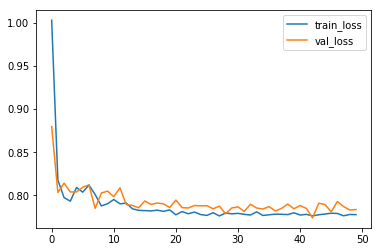

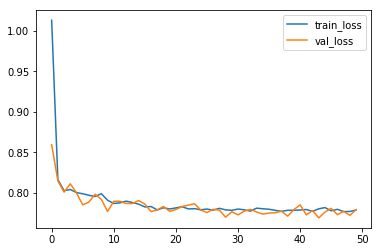

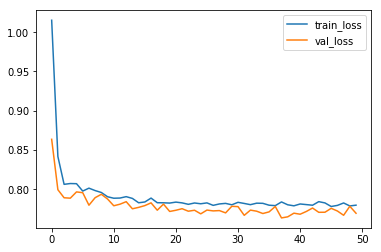

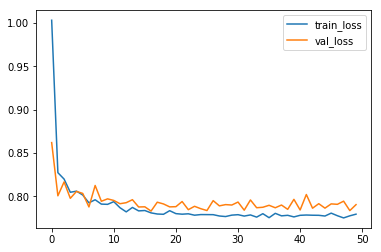

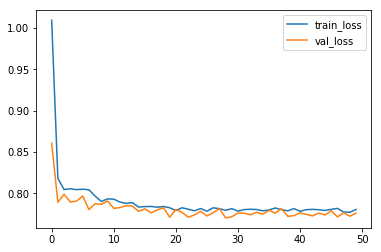

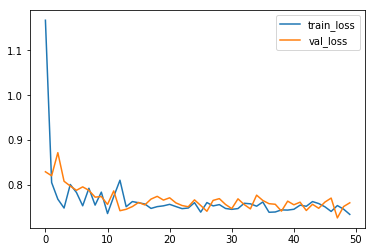

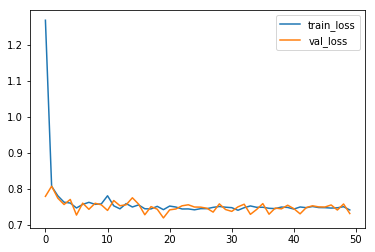

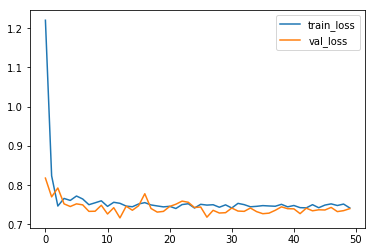

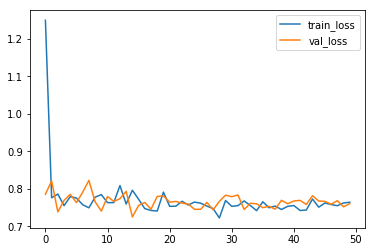

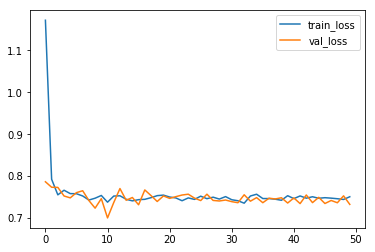

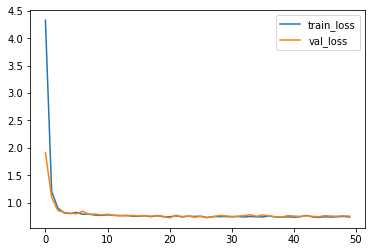

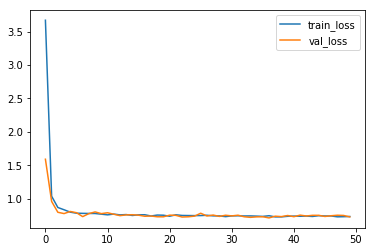

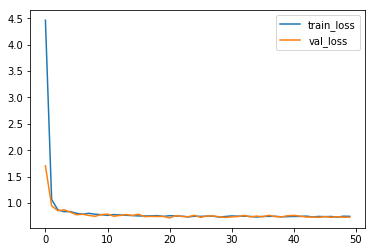

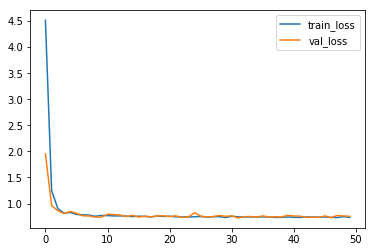

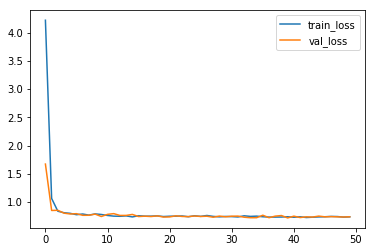

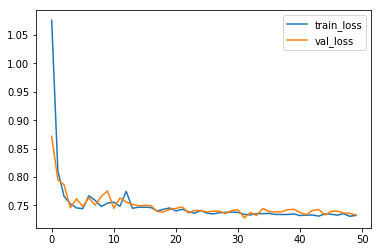

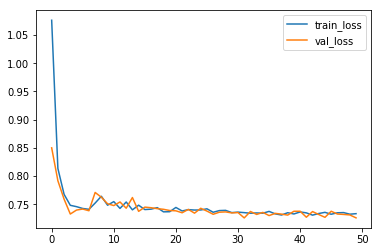

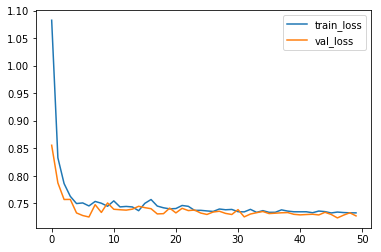

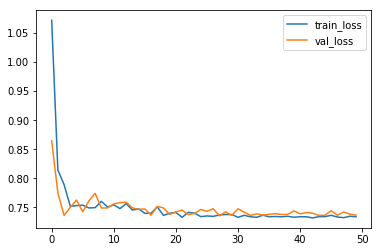

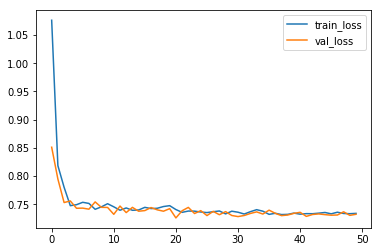

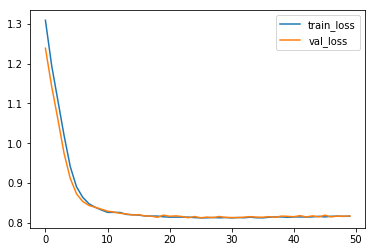

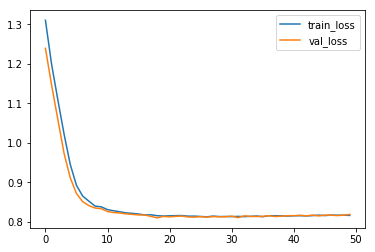

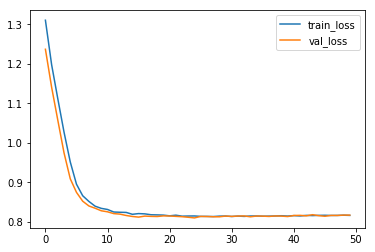

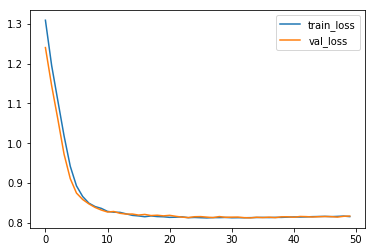

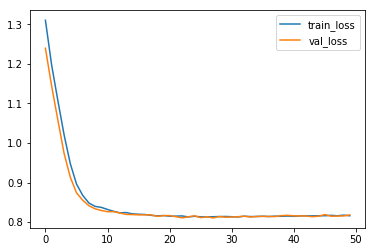

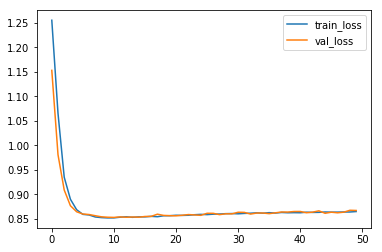

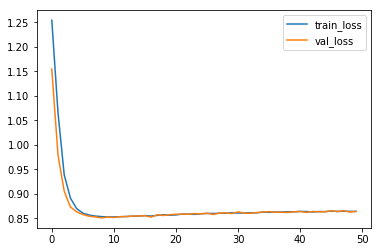

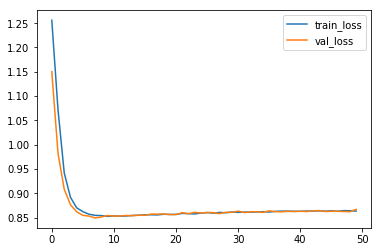

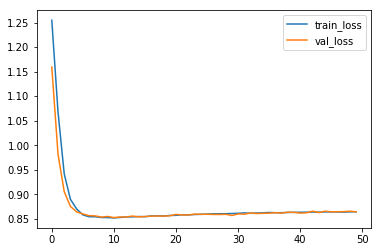

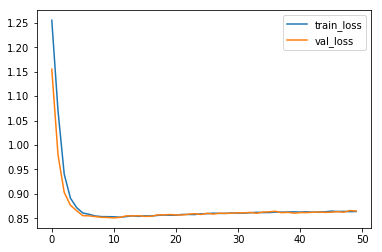

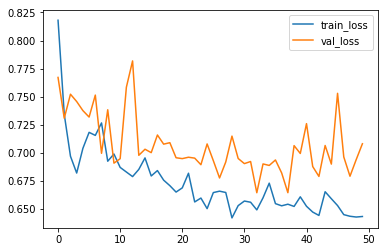

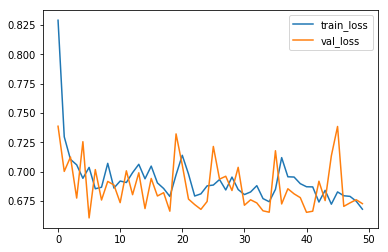

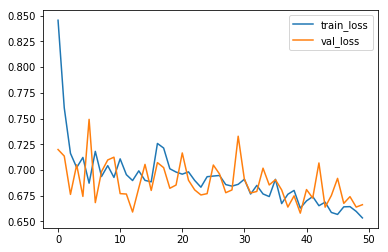

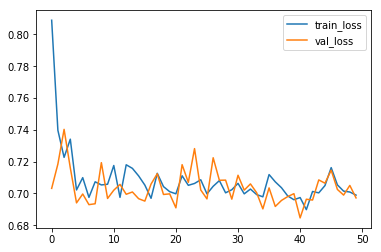

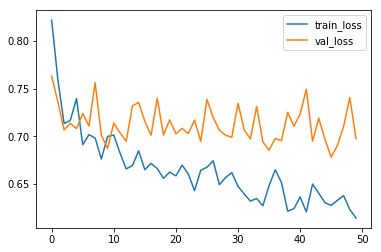

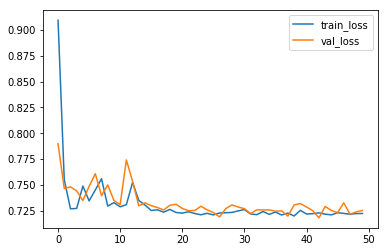

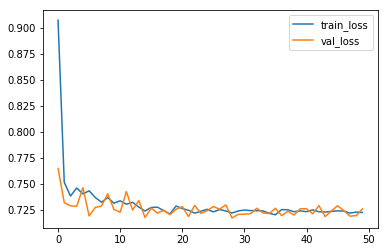

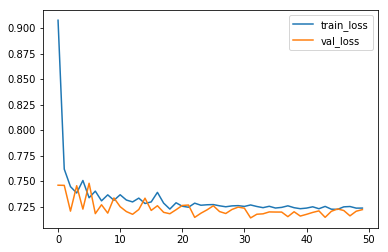

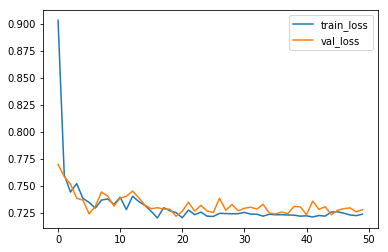

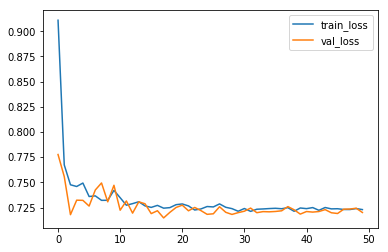

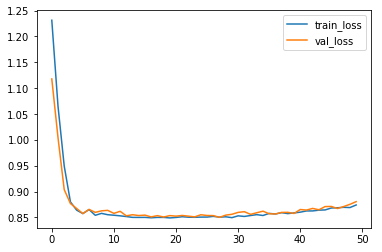

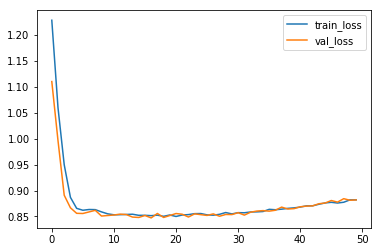

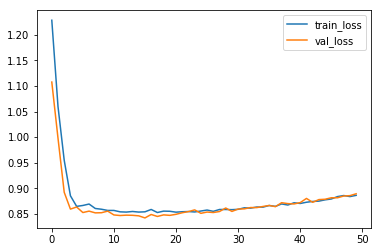

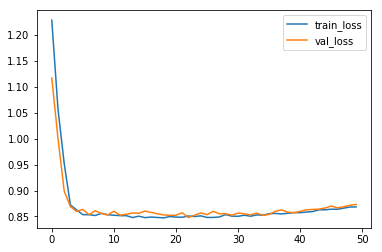

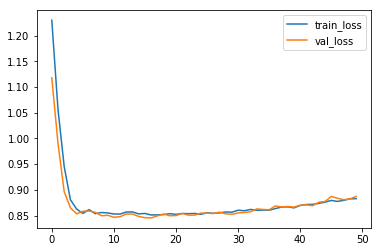

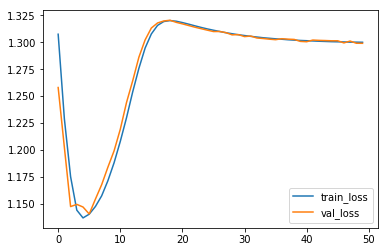

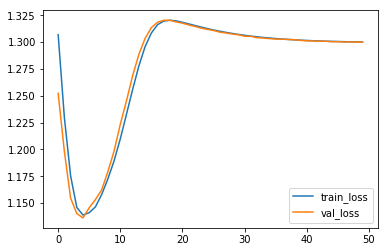

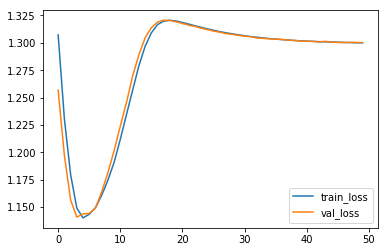

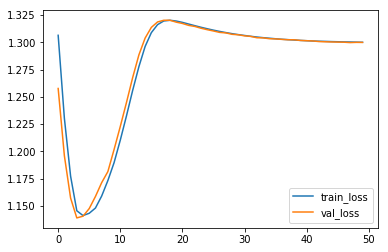

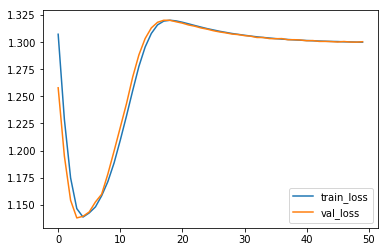

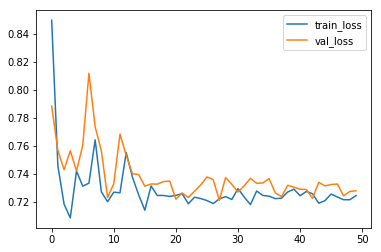

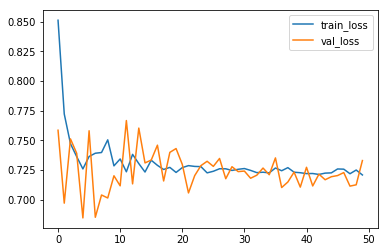

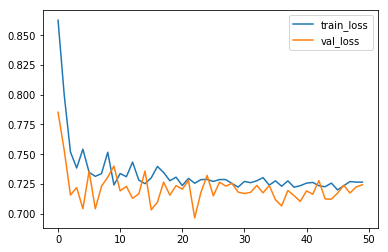

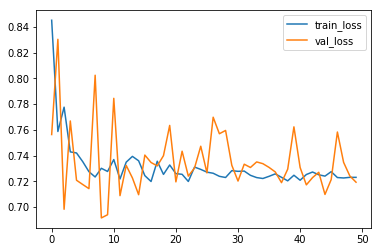

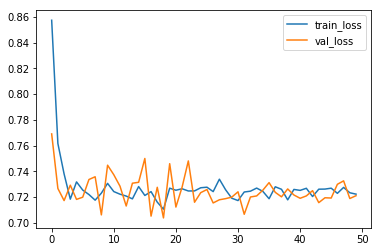

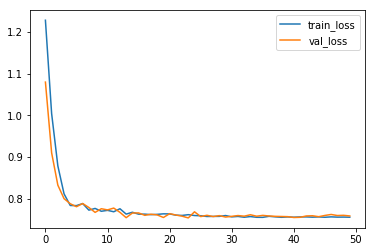

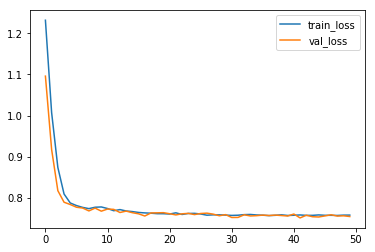

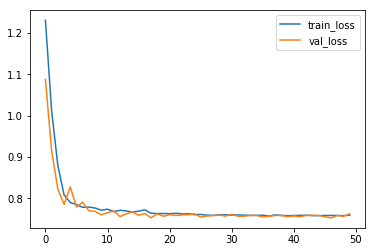

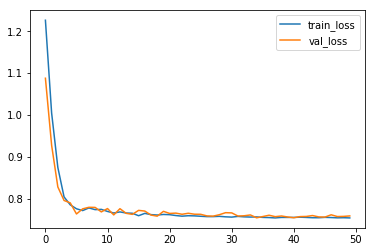

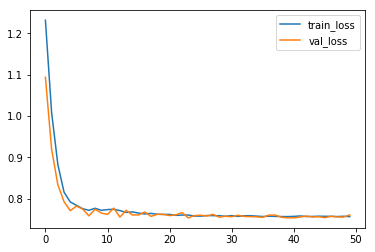

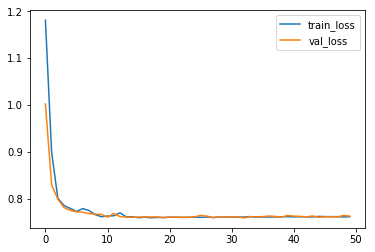

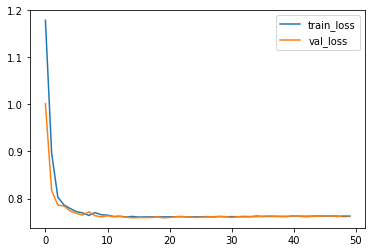

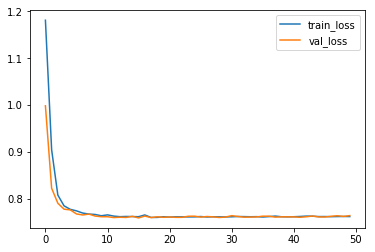

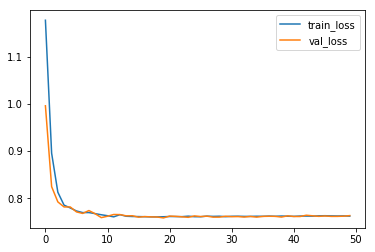

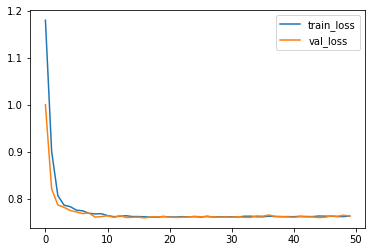

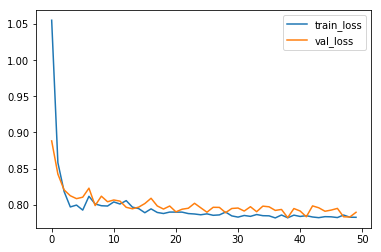

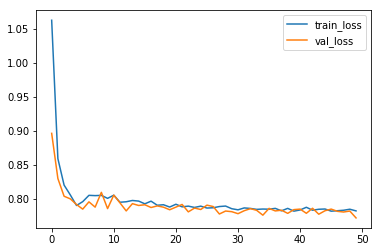

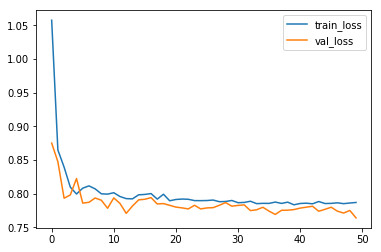

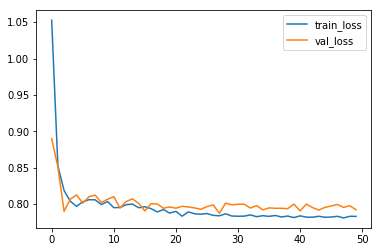

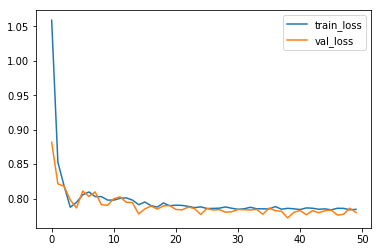

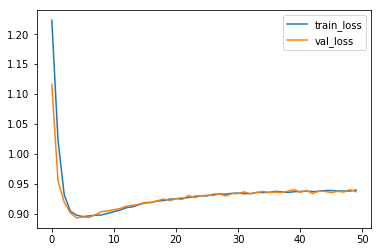

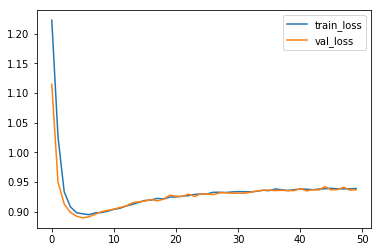

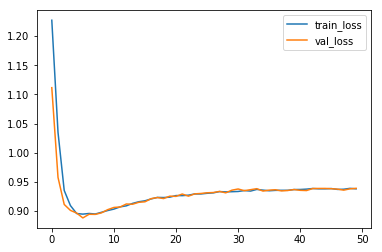

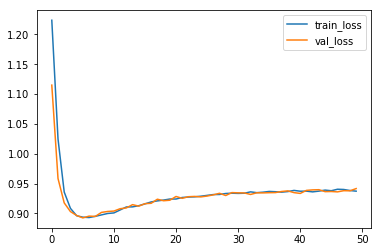

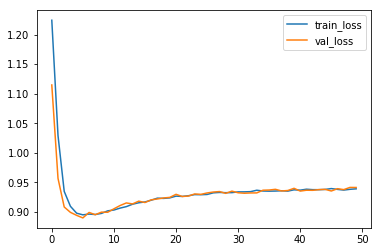

In [6]:
my_data = AutoUXDataset(data,labels,True)
my_test = AutoUXDataset(data,labels,False)

num_attempts = 15

batch_sizes = [int(np.round(2 ** random.uniform(5,7))) for i in range(num_attempts)]
hidden_dims = [int(np.round(2 ** random.normalvariate(7.5,0.562519722))) for i in range(num_attempts)]
dropouts = [random.uniform(0,0.9) for i in range(num_attempts)]
weight_decays = [np.exp(random.normalvariate(0,0.5)) for i in range(num_attempts)]
stats = []
fbs,fwd,fhd,fd = 0,0,0,0
best_acc = -999

disable = False
epochs = 50
every_other = 10

for i in range(len(batch_sizes)):
    avedloss, avedacc, avevloss, avevacc = 0,0,0,0
    batch_size = batch_sizes[i]
    weight_decay = weight_decays[i]
    hidden_dim = hidden_dims[i]
    dropout = dropouts[i]
    for i in range(5):
        torch.manual_seed(4815162342)
        model = PonceNet(dropout=dropout).cuda()
        optimizer = optim.Adam(model.parameters(), lr=3e-4,weight_decay=weight_decay)
        criterion = nn.CrossEntropyLoss()
        dlosscurve = []
        dacccurve = []
        vlosscurve = []
        vacccurve = []
        print("Fold %d" % (i + 1))
        my_data.setTest(i)
        my_test.setTest(i)

        my_loader = DataLoader(my_data, batch_size=batch_size,
                                shuffle=True)
        my_test_loader = DataLoader(my_test, batch_size=batch_size,
                                shuffle=True)
        for j in range(epochs):
            dloss, dacc = train(model,criterion,optimizer,my_loader,disable)
            vloss, vacc = test(model,criterion,my_test_loader,disable)
            dlosscurve.append(dloss)
            dacccurve.append(dacc)
            vlosscurve.append(vloss)
            vacccurve.append(vacc)
            if j % every_other == 0:
                print("Epoch Train Loss: {:.6f}  Epoch Train Accuracy: {:.6f}  Epoch Test Loss: {:.6f}  Epoch Test Accuracy: {:.6f}".format(dloss,dacc * 100,vloss,vacc * 100))
        df = pd.DataFrame(data={"train_loss": dlosscurve, "val_loss": vlosscurve})
        df.plot.line()
        avedloss += dloss
        avedacc += dacc
        avevloss += vloss
        avevacc += vacc
    avedloss /= 5
    avedacc /= 0.05
    avevloss /= 5
    avevacc /= 0.05
    if avevacc > best_acc:
        fbs,fwd,fhd,fd,best_acc = batch_size, weight_decay, hidden_dim, dropout, avevacc
    print("Batch Size: {}\nWeight Decay: {}\nHidden Dimensions: {}\nDropout: {}\n".format(batch_size,weight_decay,hidden_dim,dropout))
    print("Average Train Loss: {:.6f}\nAverage Train Accuracy: {:.6f}\nAverage Test Loss: {:.6f}\nAverage Test Accuracy: {:.6f}\n".format(avedloss,avedacc,avevloss,avevacc))
    stats.append([avedloss,avedacc,avevloss,avevacc])

In [9]:
for i in range(len(stats)):
    print("{:.2f} & {:.2f} & {:.2f} & {:.2f} & {} \\\\ \\hline".format(batch_sizes[i],weight_decays[i],hidden_dims[i],dropouts[i]," & ".join(["{:.2f}{}".format(stats[i][j],"\\%" if j % 2 == 1 else "") for j in range(len(stats[i]))])))

41.00 & 1.47 & 196.00 & 0.37 & 0.78 & 50.26\% & 0.78 & 48.05\% \\ \hline
55.00 & 1.73 & 200.00 & 0.74 & 0.75 & 52.67\% & 0.74 & 51.60\% \\ \hline
48.00 & 1.23 & 180.00 & 0.88 & 0.74 & 50.80\% & 0.74 & 50.13\% \\ \hline
75.00 & 0.69 & 228.00 & 0.29 & 0.73 & 48.89\% & 0.73 & 49.04\% \\ \hline
104.00 & 1.04 & 154.00 & 0.09 & 0.82 & 50.70\% & 0.82 & 50.18\% \\ \hline
38.00 & 1.22 & 148.00 & 0.06 & 0.86 & 50.77\% & 0.87 & 50.32\% \\ \hline
33.00 & 0.29 & 177.00 & 0.36 & 0.66 & 62.17\% & 0.69 & 58.79\% \\ \hline
33.00 & 0.52 & 360.00 & 0.27 & 0.72 & 49.63\% & 0.72 & 49.07\% \\ \hline
70.00 & 1.69 & 164.00 & 0.26 & 0.88 & 50.28\% & 0.88 & 48.86\% \\ \hline
58.00 & 2.50 & 212.00 & 0.15 & 1.30 & 51.04\% & 1.30 & 53.49\% \\ \hline
44.00 & 0.67 & 238.00 & 0.43 & 0.72 & 50.66\% & 0.73 & 45.11\% \\ \hline
84.00 & 0.75 & 231.00 & 0.16 & 0.76 & 49.78\% & 0.76 & 48.32\% \\ \hline
40.00 & 0.63 & 372.00 & 0.03 & 0.76 & 50.59\% & 0.76 & 49.62\% \\ \hline
74.00 & 1.64 & 140.00 & 0.41 & 0.78 & 49.50\% & 0.

In [11]:
# hyperparameters
batch_size = fbs
weight_decay = fwd
hidden_dim = fhd
dropout = fd
disable = False
epochs = 50
every_other = 10

# initializing training objects
torch.manual_seed(4815162342)
model = PonceNet(dropout=dropout).cuda()
optimizer = optim.Adam(model.parameters(), lr=3e-4,weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

# initializing dataset
my_data = AutoUXDataset(data,labels,True)
my_val = AutoUXDataset(dataVal,labelsVal,False,True)
my_loader = DataLoader(my_data, batch_size=batch_size,shuffle=True)
my_val_loader = DataLoader(my_val, batch_size=batch_size,shuffle=True)
my_data.setTest(-1)
my_val.setTest(-1)

# initializing tracking variables
dlosscurve = []
dacccurve = []
vlosscurve = []
vacccurve = []

# training loop
for j in range(epochs):
    dloss, dacc = train(model,criterion,optimizer,my_loader,disable)
    vloss, vacc = test(model,criterion,my_val_loader,disable)
    dlosscurve.append(dloss)
    dacccurve.append(dacc)
    vlosscurve.append(vloss)
    vacccurve.append(vacc)
    if j % every_other == 0:
        print("Epoch Train Loss: {:.6f}  Epoch Train Accuracy: {:.6f}  Epoch Test Loss: {:.6f}  Epoch Test Accuracy: {:.6f}".format(dloss,dacc * 100,vloss,vacc * 100))

print("Batch Size: {}\nWeight Decay: {}\nHidden Dimensions: {}\nDropout: {}\n".format(batch_size,weight_decay,hidden_dim,dropout))
print("Train Loss: {:.6f}\nTrain Accuracy: {:.6f}\nValidation Loss: {:.6f}\nValidation Accuracy: {:.6f}\n".format(dloss,dacc * 100,vloss,vacc * 100))
print("{} & {:.2f} & {} & {:.2f} & {:.2f}\% & {:.2f} & {:.2f}\% \\\\ \\hline".format(batch_size,weight_decay,hidden_dim,dropout,dloss,dacc * 100,vloss, vacc * 100))

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 19.98it/s]


Epoch Train Loss: 0.814521  Epoch Train Accuracy: 49.837662  Epoch Test Loss: 0.771146  Epoch Test Accuracy: 56.818182


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 19.59it/s]


Epoch Train Loss: 0.700711  Epoch Train Accuracy: 55.465368  Epoch Test Loss: 0.690723  Epoch Test Accuracy: 54.924242


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 19.40it/s]


Epoch Train Loss: 0.706781  Epoch Train Accuracy: 55.303030  Epoch Test Loss: 0.674085  Epoch Test Accuracy: 73.863636


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.65it/s]


Epoch Train Loss: 0.711445  Epoch Train Accuracy: 54.058442  Epoch Test Loss: 0.682749  Epoch Test Accuracy: 63.636364


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 19.03it/s]


Epoch Train Loss: 0.679106  Epoch Train Accuracy: 61.471861  Epoch Test Loss: 0.712607  Epoch Test Accuracy: 50.000000


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 19.21it/s]


Batch Size: 33
Weight Decay: 0.29059356651996
Hidden Dimensions: 177
Dropout: 0.360434106788504

Train Loss: 0.657686
Train Accuracy: 63.528139
Validation Loss: 0.649131
Validation Accuracy: 57.954545

33 & 0.29 & 177 & 0.36 & 0.66\% & 63.53 & 0.65\% \\ \hline


In [ ]:
answers = np.array([])
preds = np.array([])
with torch.no_grad():
    for s in tqdm(my_val,disable=disable):
        x, y = s.values()
        x = x.cuda()
        y = y.cuda()
        y_pred = model(x).cpu()
        answers = np.append(answers,y_pred[:,1])
        preds = np.append(preds,torch.max(y_pred,1)[1])
answers = np.exp(answers)
print(answers)
print(preds)

In [ ]:
false_pos = []
false_neg = []

for i in range(0,len(answers)):
#     print("{} Predicted: {} \t Actual: {}".format(images[i],int(preds[i]),int(labels[i])))
    if int(labels[i]) < int(preds[i]):
        false_neg.append(images[i])
    elif int(labels[i]) > int(preds[i]):
        false_pos.append(images[i])
print("False Positives:")
for x in false_pos:
    print(x)
print("\nFalse Negatives:")
for x in false_neg:
    print(x)

In [ ]:
with open('PonceNetoutprobs.pt', 'wb') as f:
    pickle.dump(answers, f)

In [ ]:
from sklearn.metrics import *
import itertools
import pickle
with open('PonceNetout.pt', 'rb') as f:
    y_pred = pickle.load(f)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


y_test = np.array([])

for x in labels:
    y_test = np.append(y_test,x)

class_names = ["bad site","good site"]

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
print("Accuracy: {:.4f}".format(np.mean(y_test==y_pred)))